<a href="https://colab.research.google.com/github/farhanhubble/AIND-Planning/blob/master/advanced_lane_detection_Jun21_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!ls /content/drive/My\ Drive/data_driver_view | head -10

00002207.png
00002208.png
00002209.png
00002210.png
00002211.png
00002212.png
00002213.png
00002214.png
00002215.png
00002216.png


In [50]:
def plot_img_grid(images, nb_cols,row_height=4):
    nb_images = len(images)
    nb_rows = int(np.ceil(nb_images/nb_cols))
    
    for i in range(nb_rows):
        plt.figure(figsize=(32, row_height))
        for j in range(nb_cols):
            image_index = i*nb_cols + j
            if image_index >= nb_images:
              break

            plt.subplot(1, nb_cols, j+1) 
            image = images[image_index]
            nb_channels = 1 if len(image.shape) == 2 else image.shape[-1]
            plt.imshow(image, cmap='gray' if nb_channels == 1 else None)
            plt.xticks([])
            plt.yticks([])
        plt.show()

In [37]:
import os
from glob import glob
from tqdm import tqdm

data_cache = '/content/drive/My Drive/data_driver_view/road_data.npy'
if os.path.exists(data_cache):
  print('Loading data from cache...')
  road_data = np.load(data_cache)
  print(f'Data with dimensions {road_data.shape} loaded.')
else:
  road_data = []
  os.makedirs('./cache',exist_ok=True)
  filenames = glob('/content/drive/My Drive/data_driver_view/*.png')
  print('Loading data from Google Drive')
  for name in tqdm(filenames):
    img_bgr = cv2.imread(name)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    road_data.append(img_rgb)
  road_data = np.array(road_data)
  np.save(data_cache,road_data)
  print(f'{len(road_data)} images loaded')

Loading data from cache...
Data with dimensions (355, 720, 1280, 3) loaded.


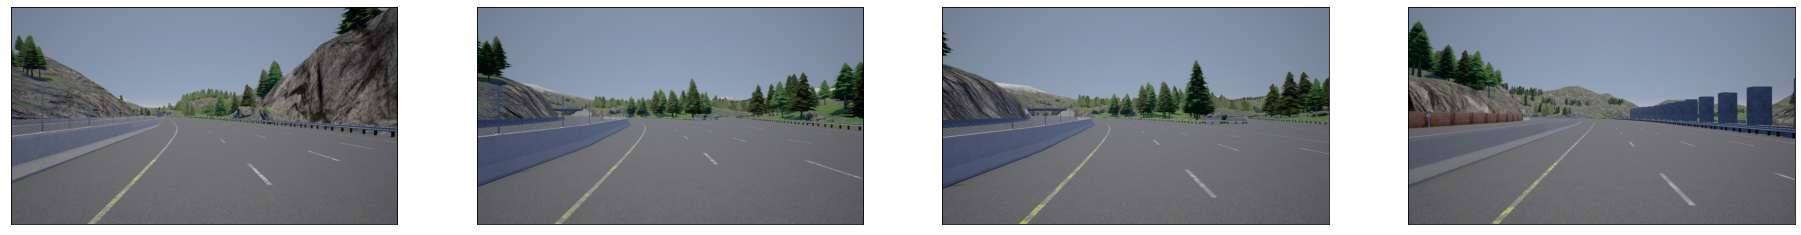

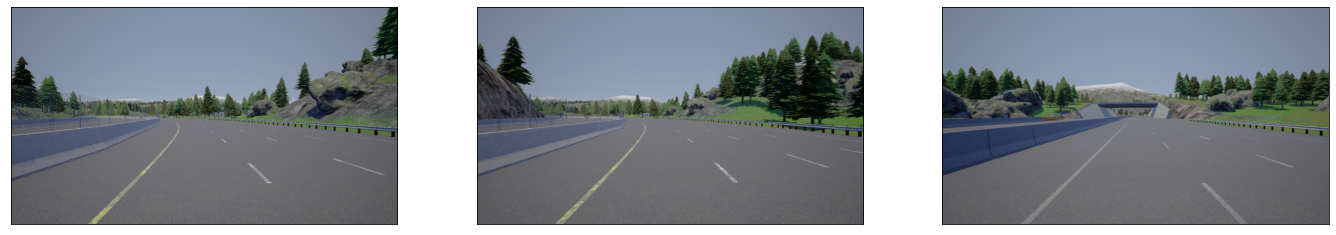

In [43]:
# Plot a few random data points
indices = list(range(len(road_data)))
random_indices = np.random.choice(indices,7)
plot_img_grid(road_data[random_indices],4)

In [27]:
grad_x = cv2.Sobel(road_data[0], cv2.CV_32F, 1, 0)
grad_y = cv2.Sobel(road_data[0], cv2.CV_32F, 0, 1)

abs_grad_x = abs(grad_x)
abs_grad_y = abs(grad_y)

#Scale gradients channel-wise, ensure zero gradients map to zero 
max_channelwise_x = np.max(abs_grad_x, axis=(0,1))
max_channelwise_y = np.max(abs_grad_y, axis=(0,1))


grad_x_scaled = (abs_grad_x)/(max_channelwise_x )
grad_y_scaled = (abs_grad_y)/(max_channelwise_y )
grad_x_y_scaled = np.sqrt(grad_x_scaled**2+grad_y_scaled**2)/2**.5

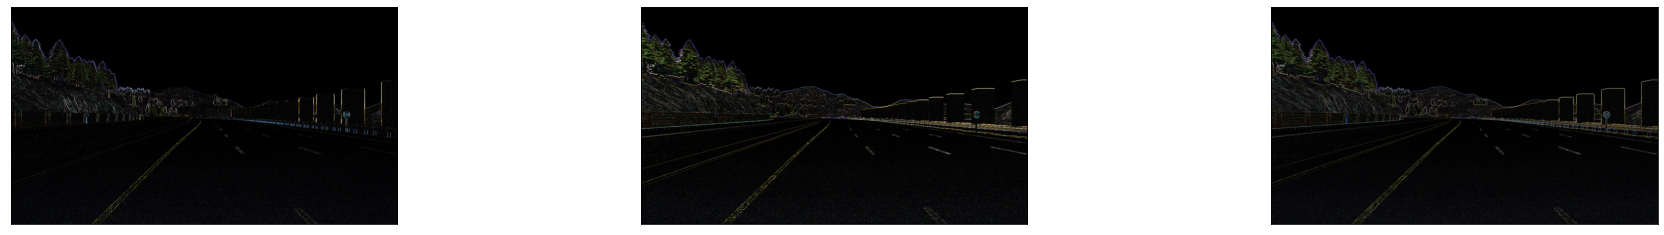

In [28]:
plot_img_grid([grad_x_scaled, 
               grad_y_scaled,
               grad_x_y_scaled]
              ,3)

In [32]:
# Convert to binary value.
# Otsu's requires intensities 
grad_x_rescaled = (grad_x_scaled * 255).astype(np.uint8)
grad_y_rescaled = (grad_y_scaled * 255).astype(np.uint8)
grad_x_y_rescaled = (grad_x_y_scaled * 255).astype(np.uint8)

_, bin_grad_x = cv2.threshold(grad_x_rescaled[:,:,0], 0, 255, cv2.THRESH_OTSU+cv2.THRESH_BINARY)
_, bin_grad_y = cv2.threshold(grad_y_rescaled[:,:,0], 0, 255, cv2.THRESH_OTSU+cv2.THRESH_BINARY)
_, bin_grad_x_y = cv2.threshold(grad_x_y_rescaled[:,:,0], 0, 255, cv2.THRESH_OTSU+cv2.THRESH_BINARY)

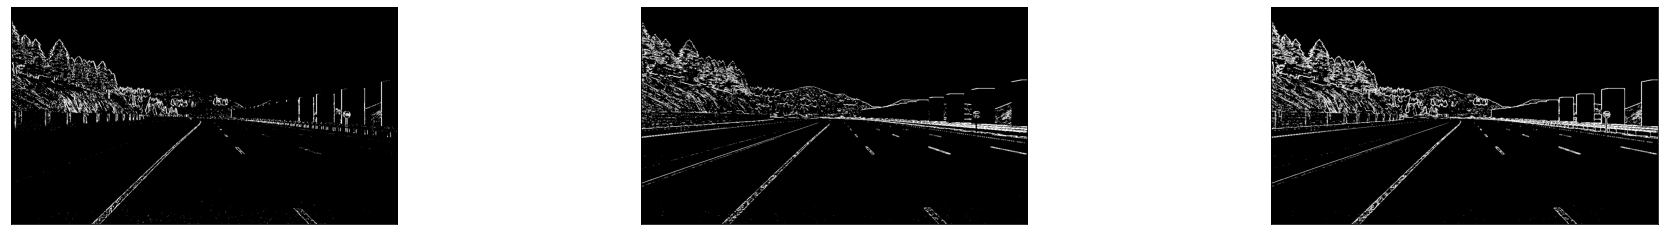

In [33]:
plot_img_grid([bin_grad_x,
               bin_grad_y,
               bin_grad_x_y],3);

In [46]:
#find the connected components
retval, labels, stats, centroids = cv2.connectedComponentsWithStats(bin_grad_x_y)

# Find the top 10 components
top_components_index = np.argsort(stats[:, -1])[-1:-31:-1]
top_components = stats[top_components_index, -1]


# Plot the connected components
components = []
for component_id in top_components_index:
  condition_array = np.rollaxis(np.stack((labels == component_id, labels == component_id, labels == component_id)), 0, 3)
  component = np.where(condition_array, road_data[0], np.zeros_like(road_data[0]))
  components.append(component)

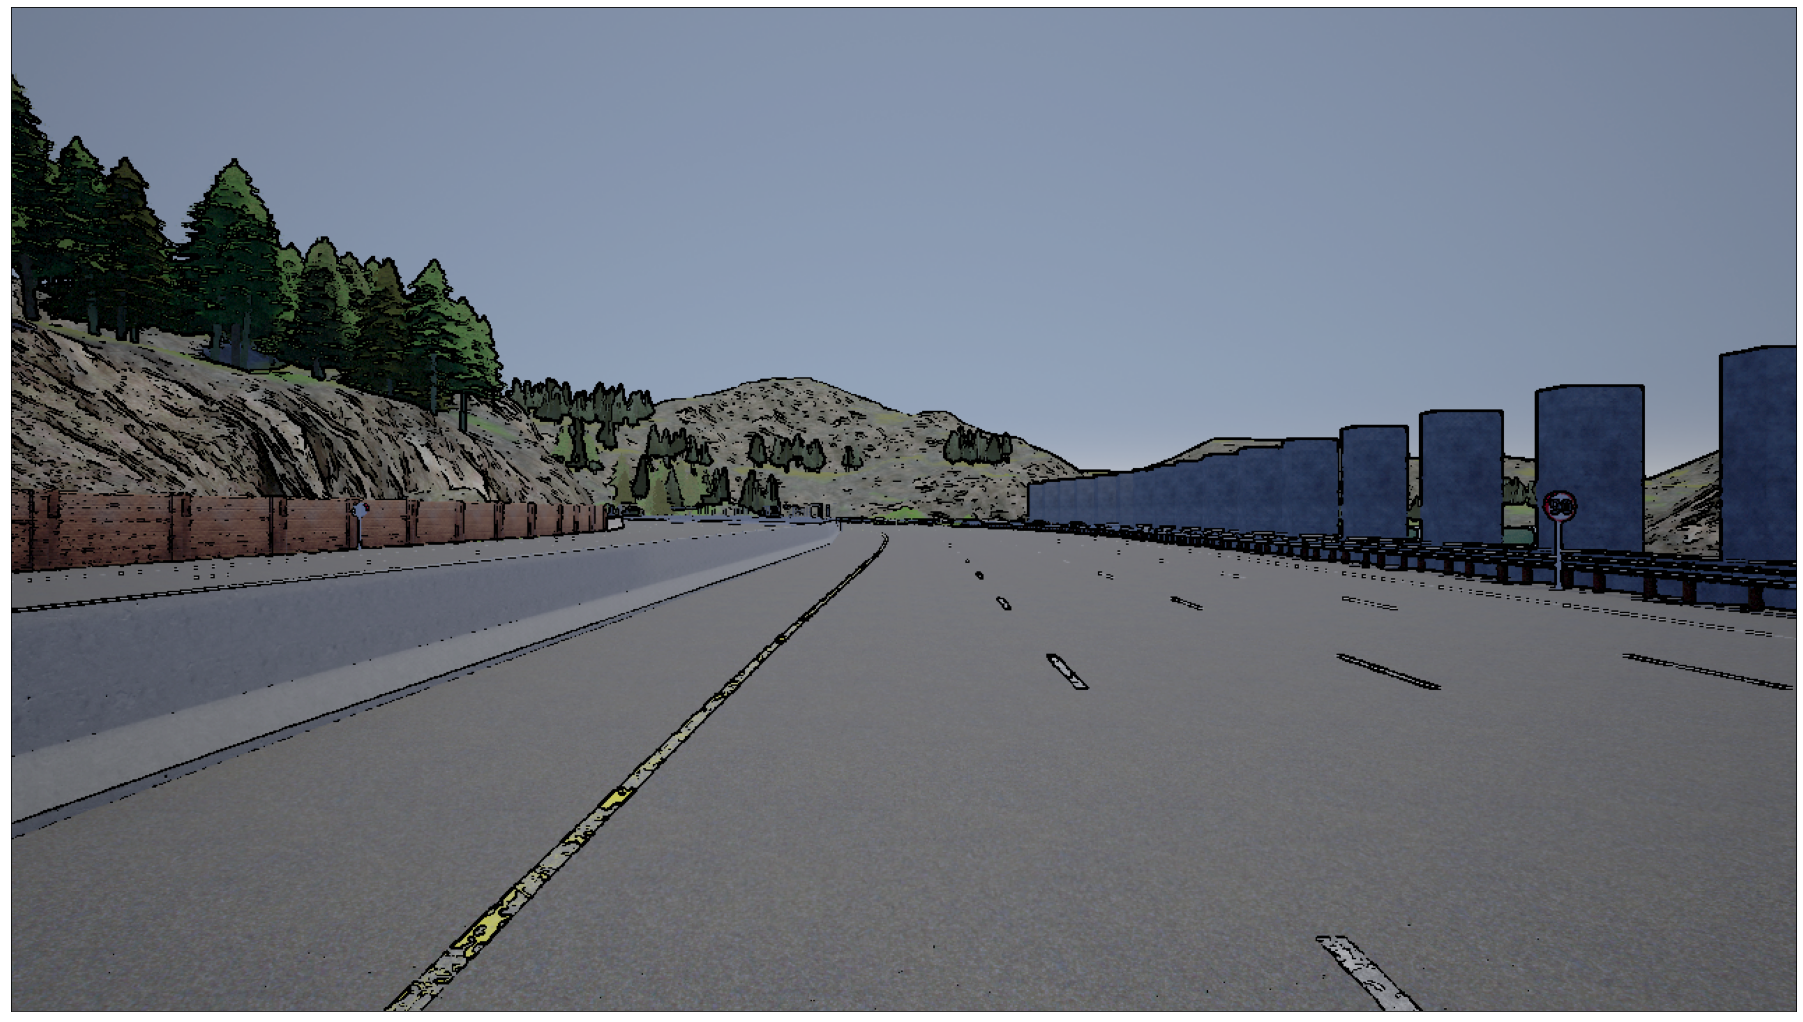

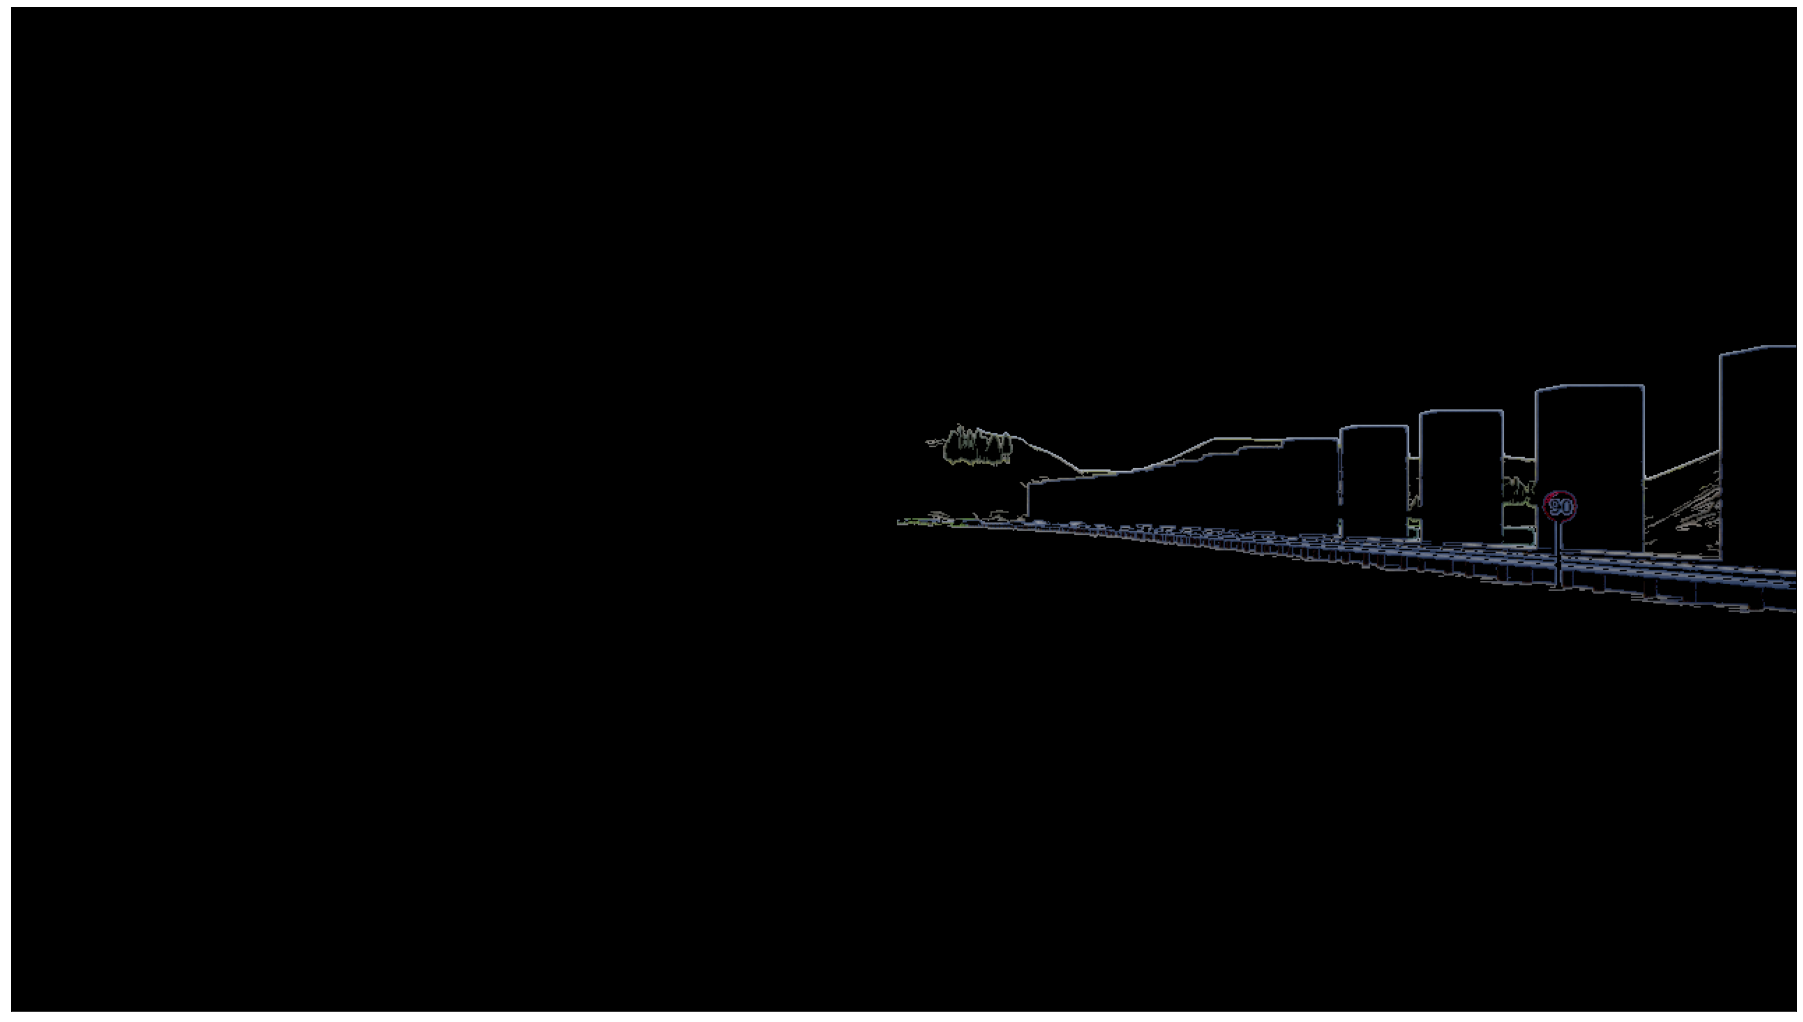

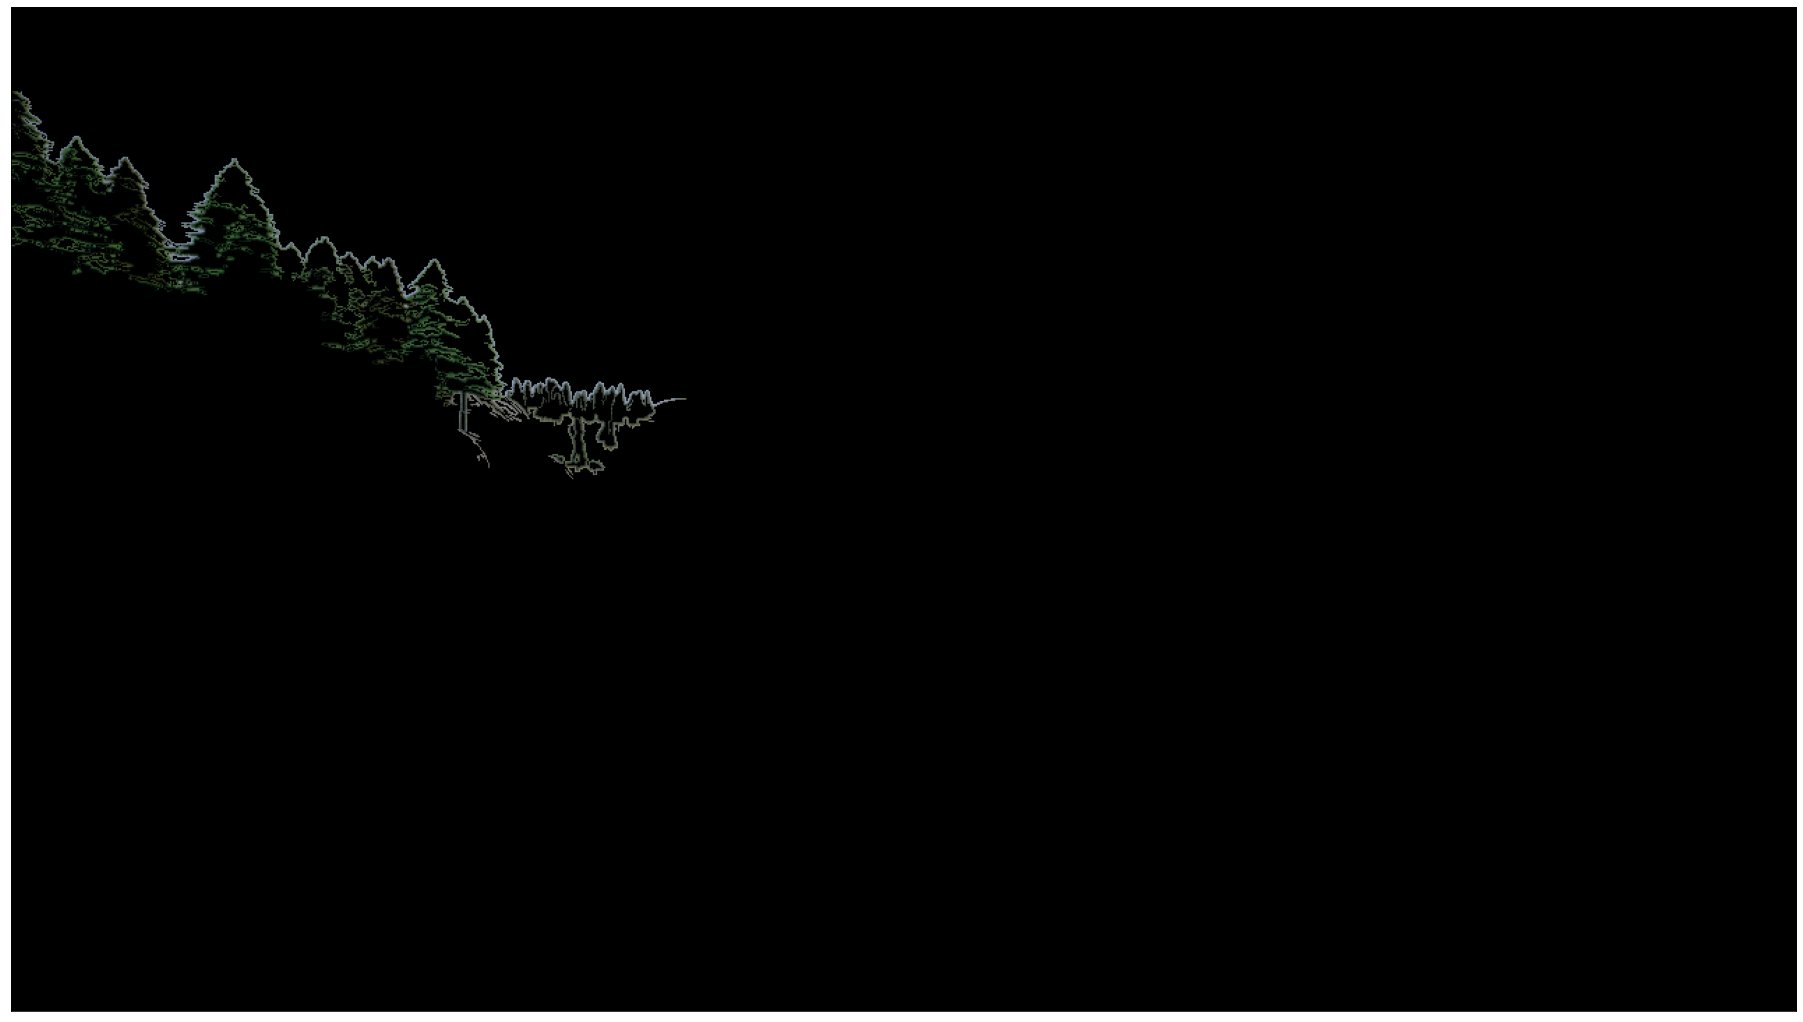

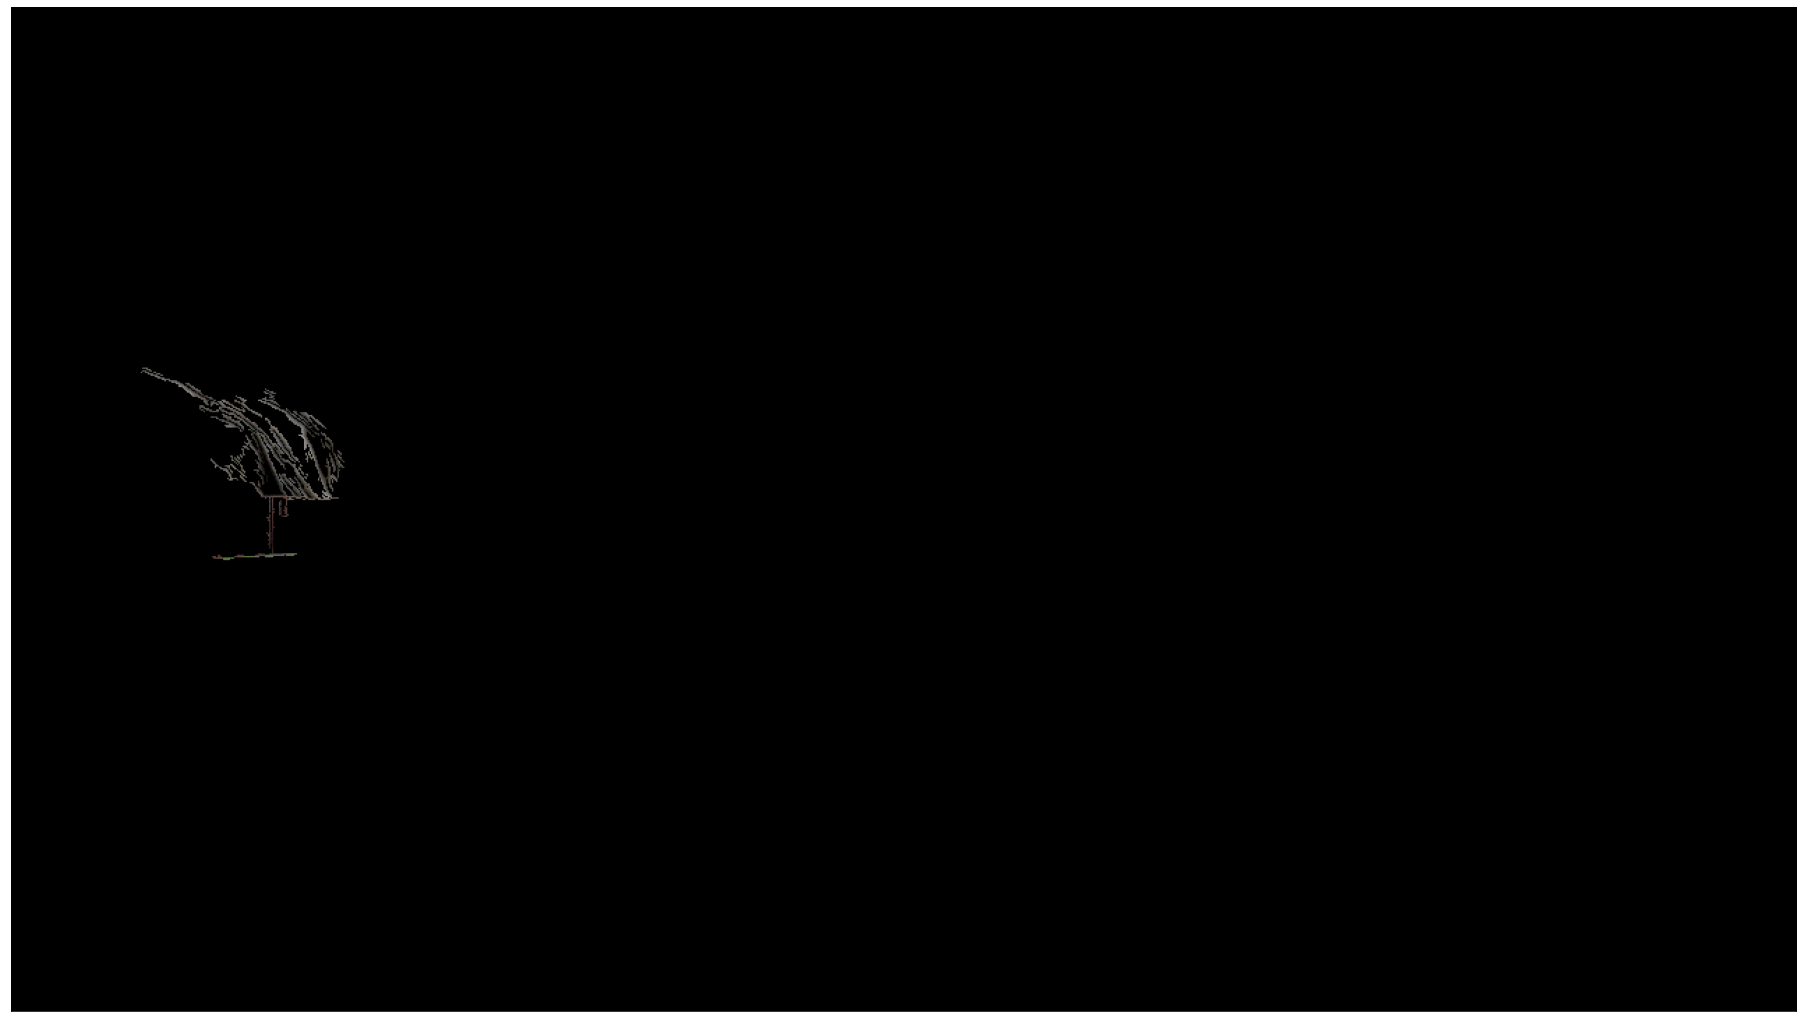

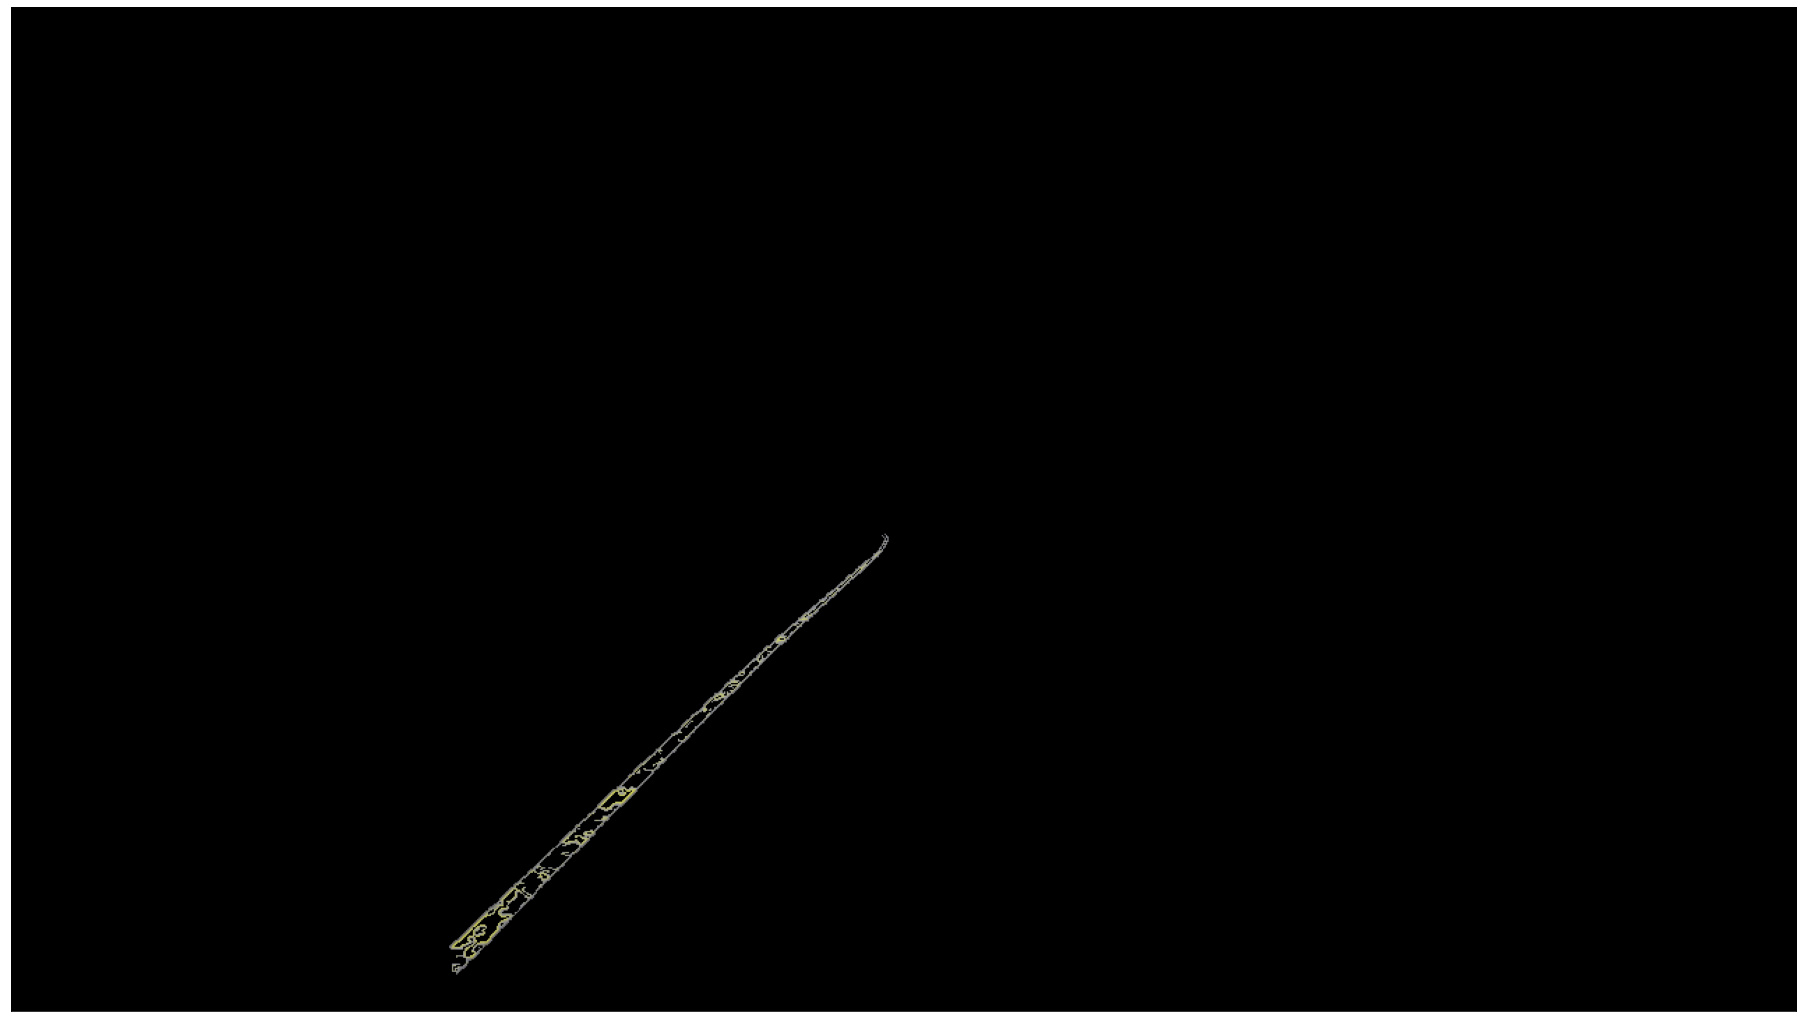

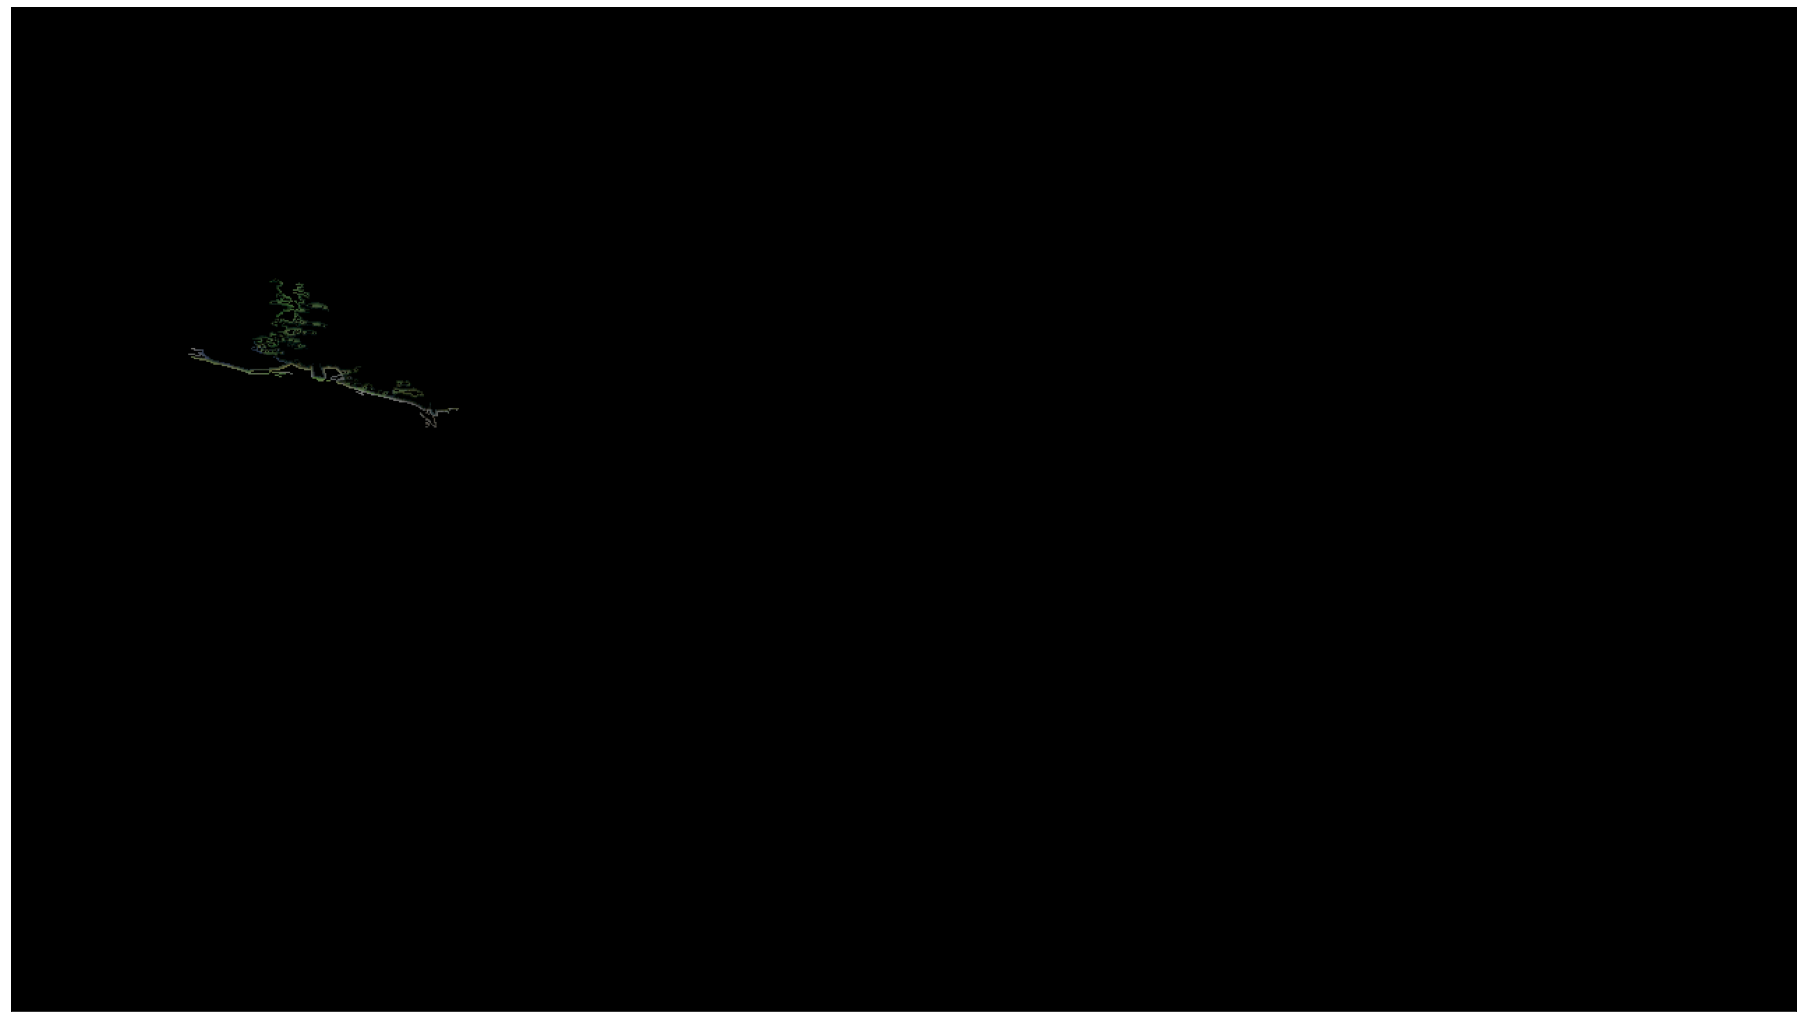

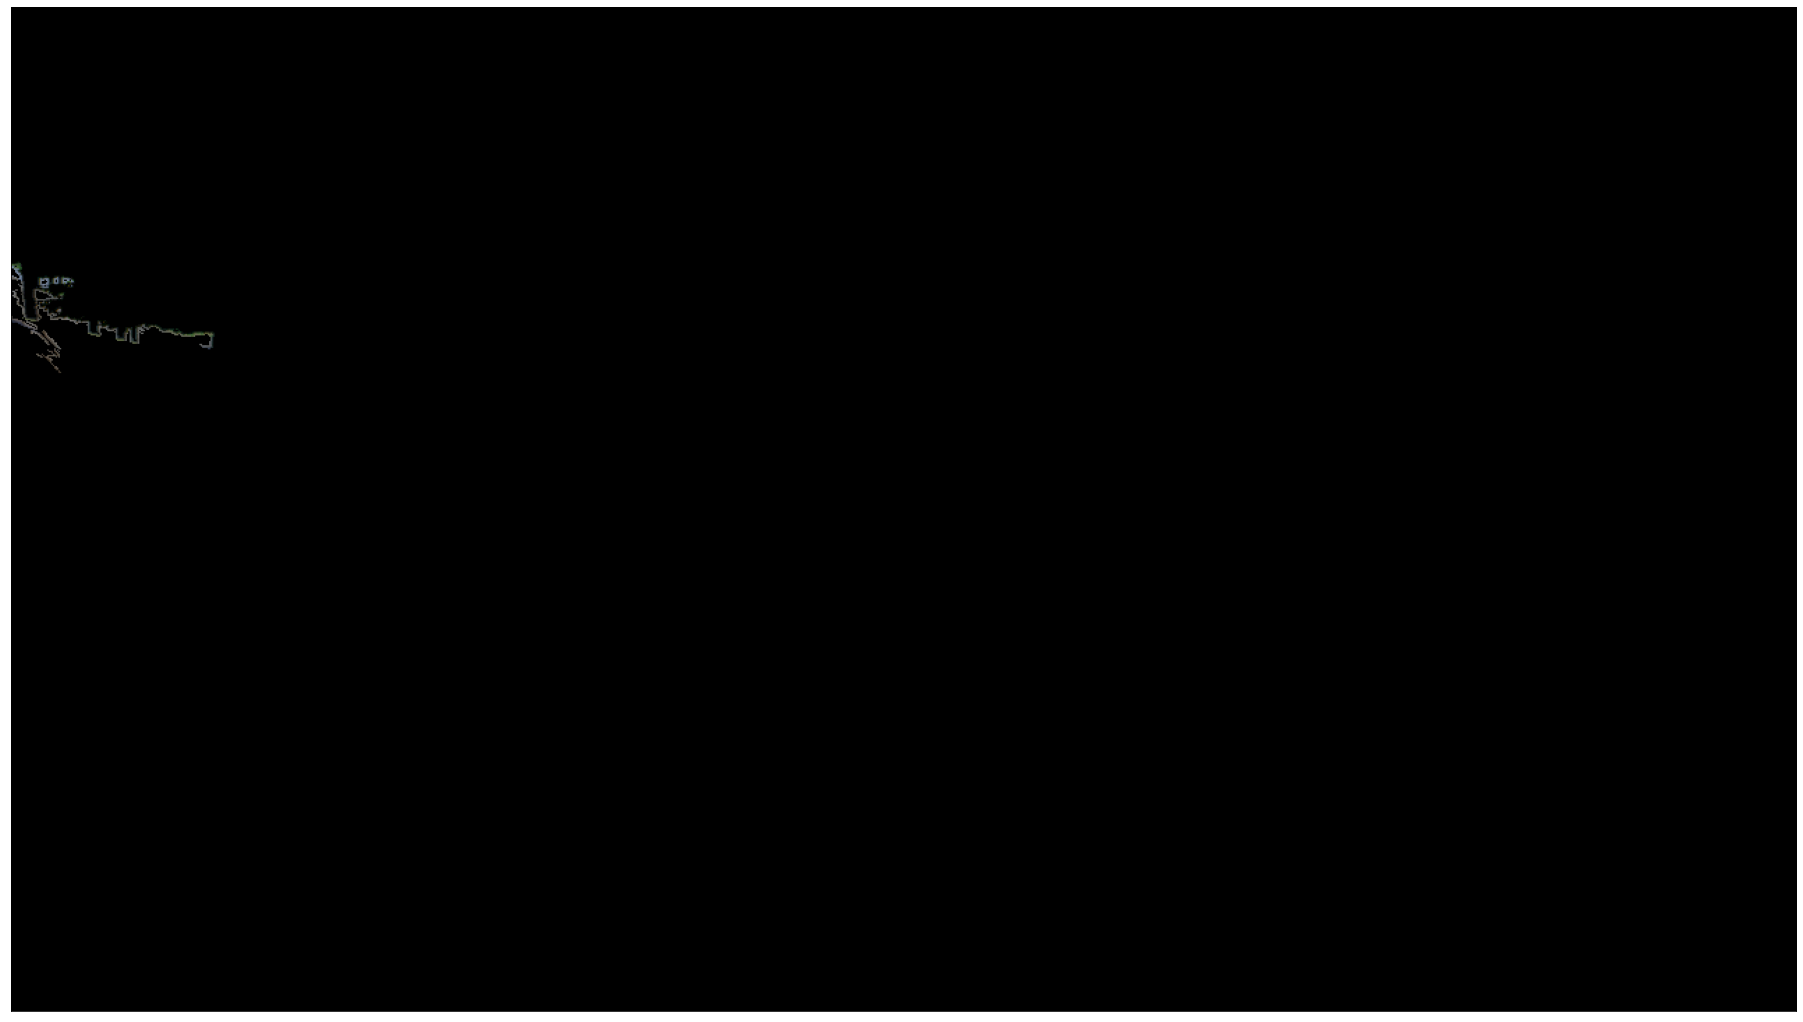

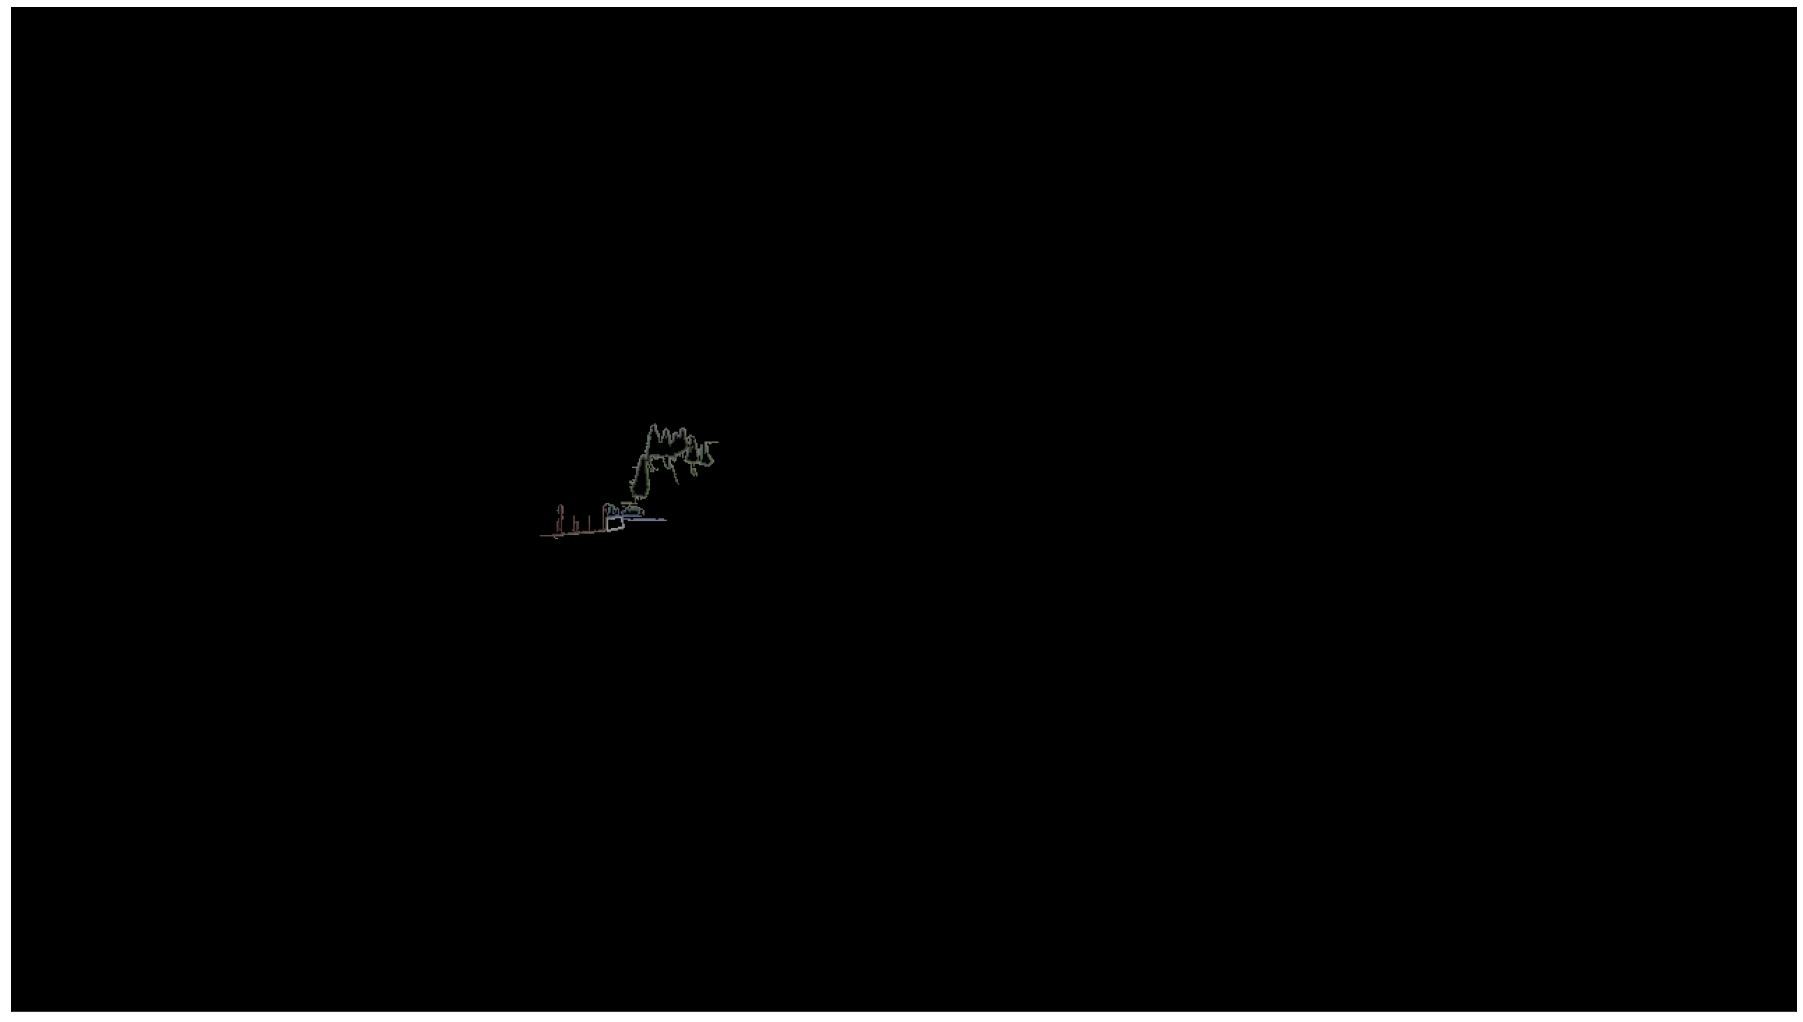

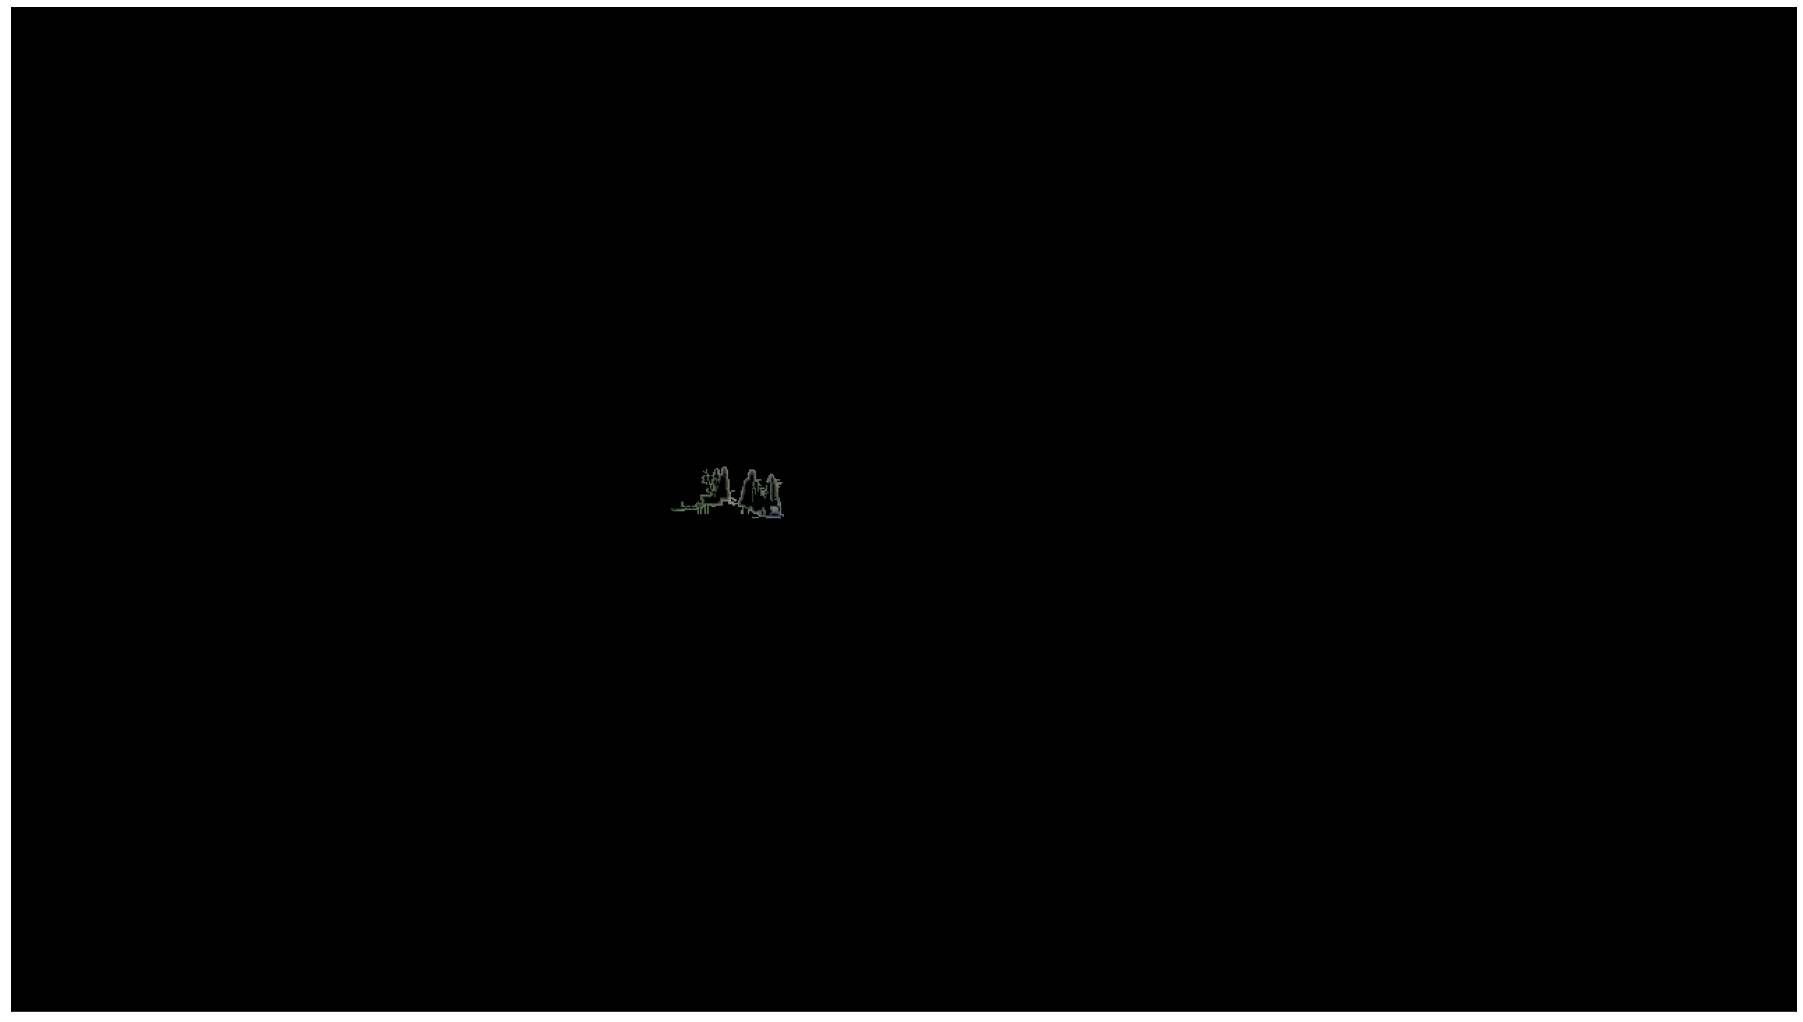

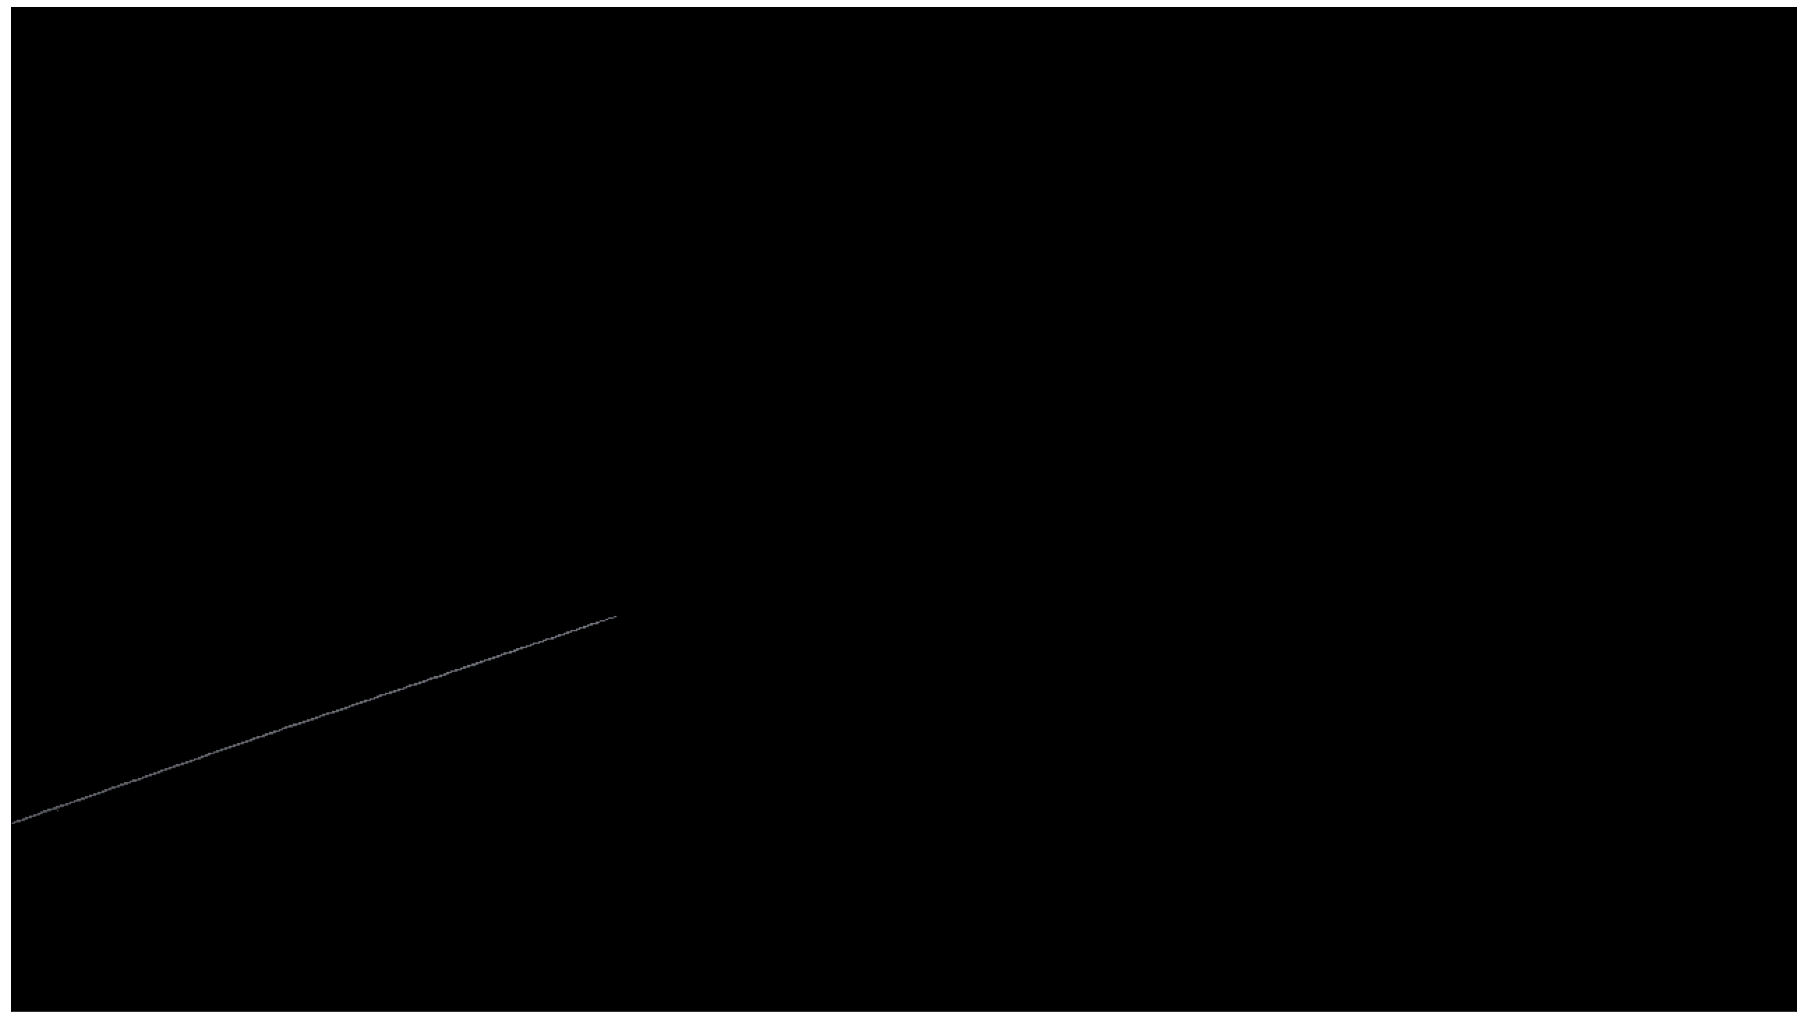

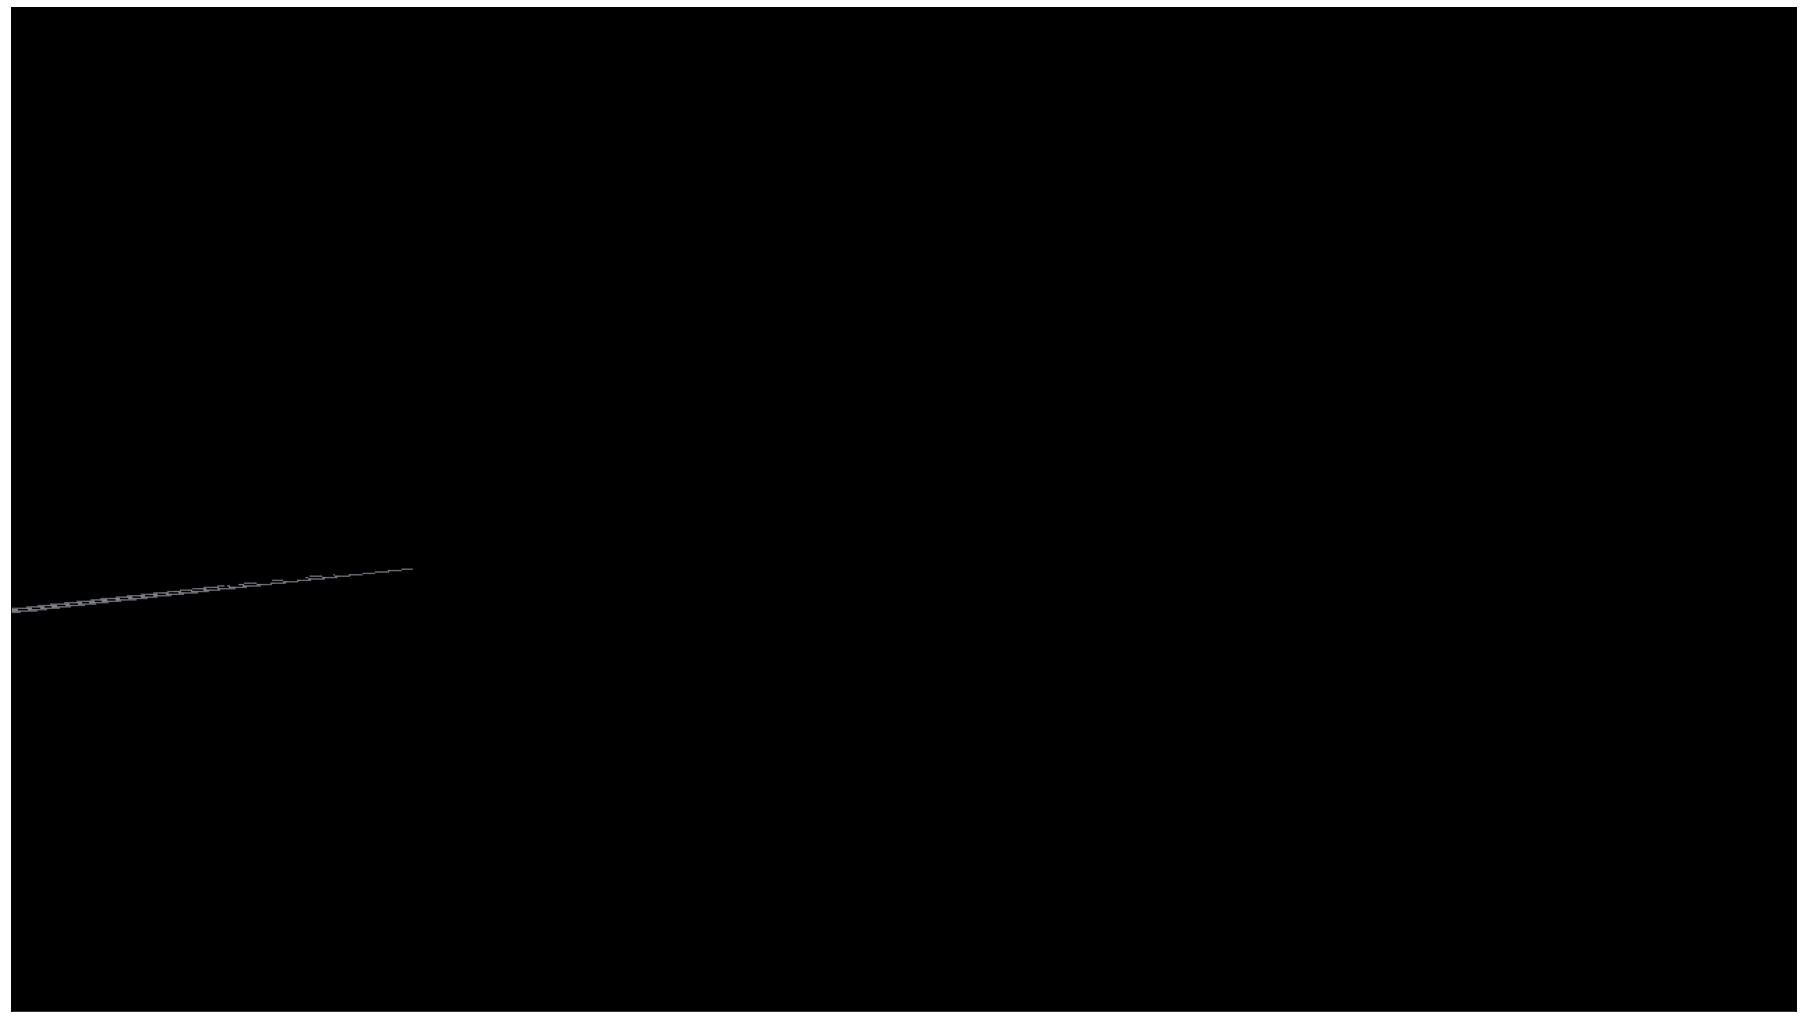

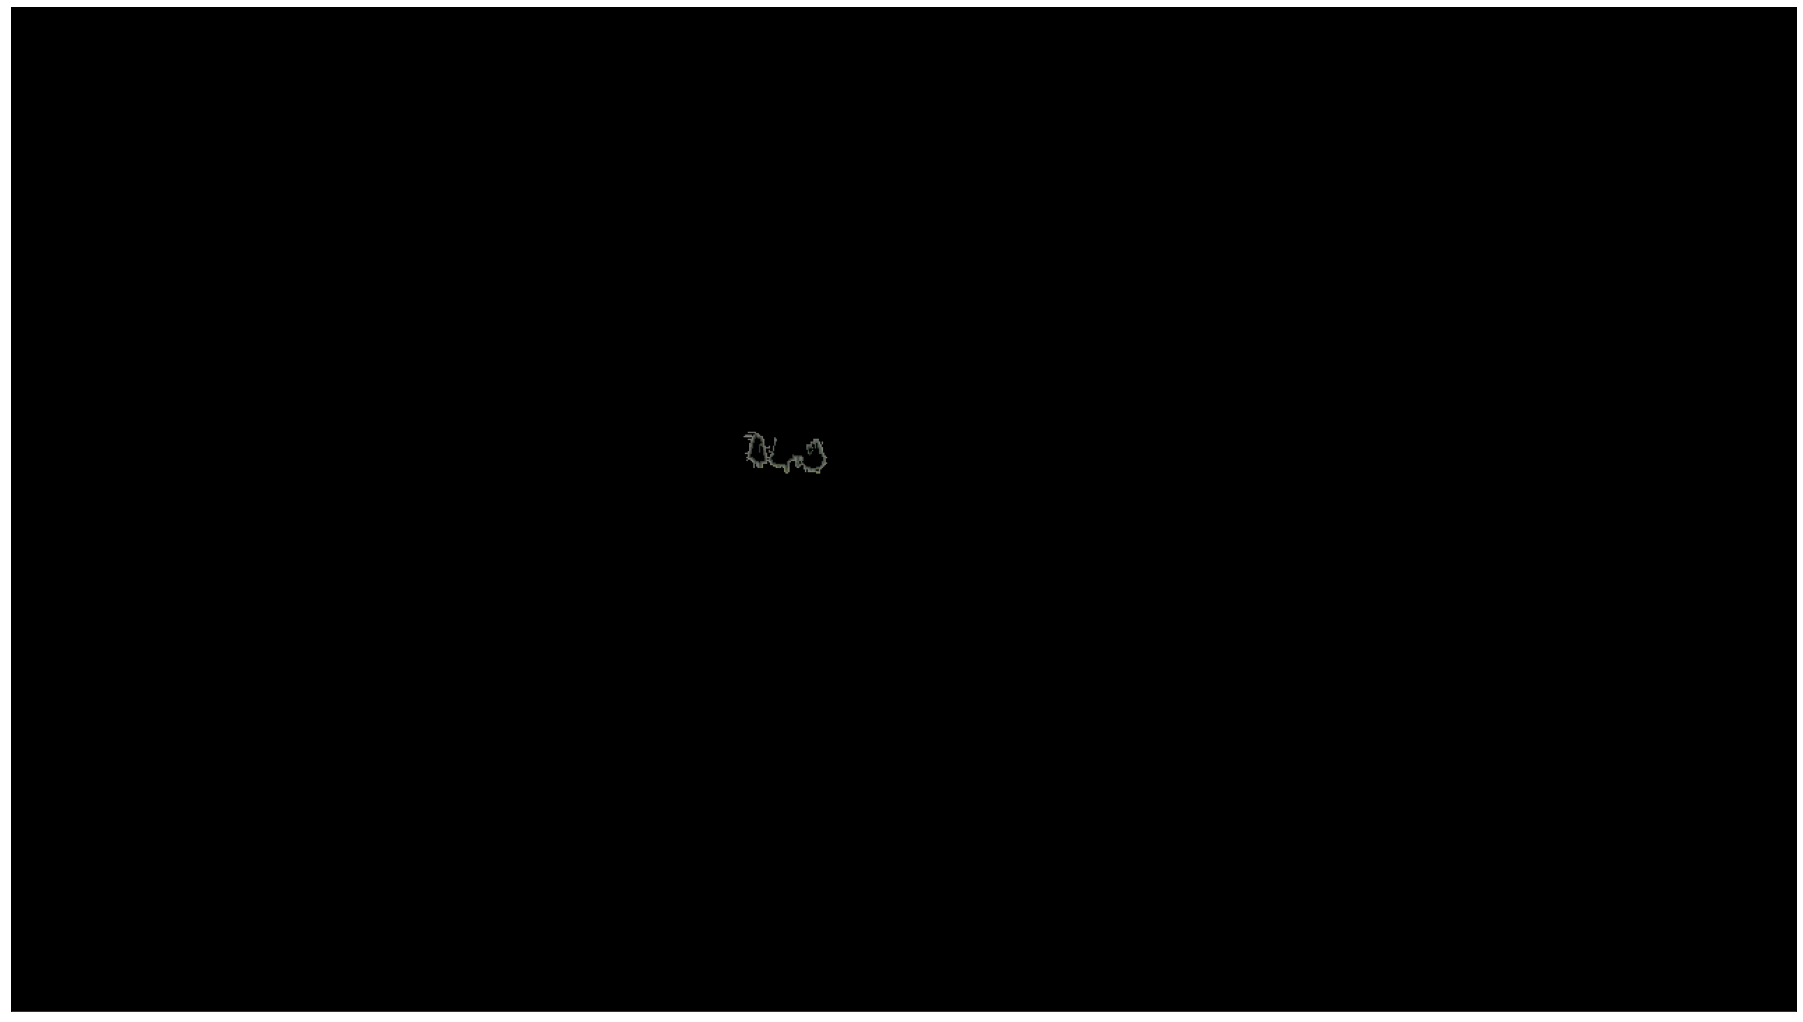

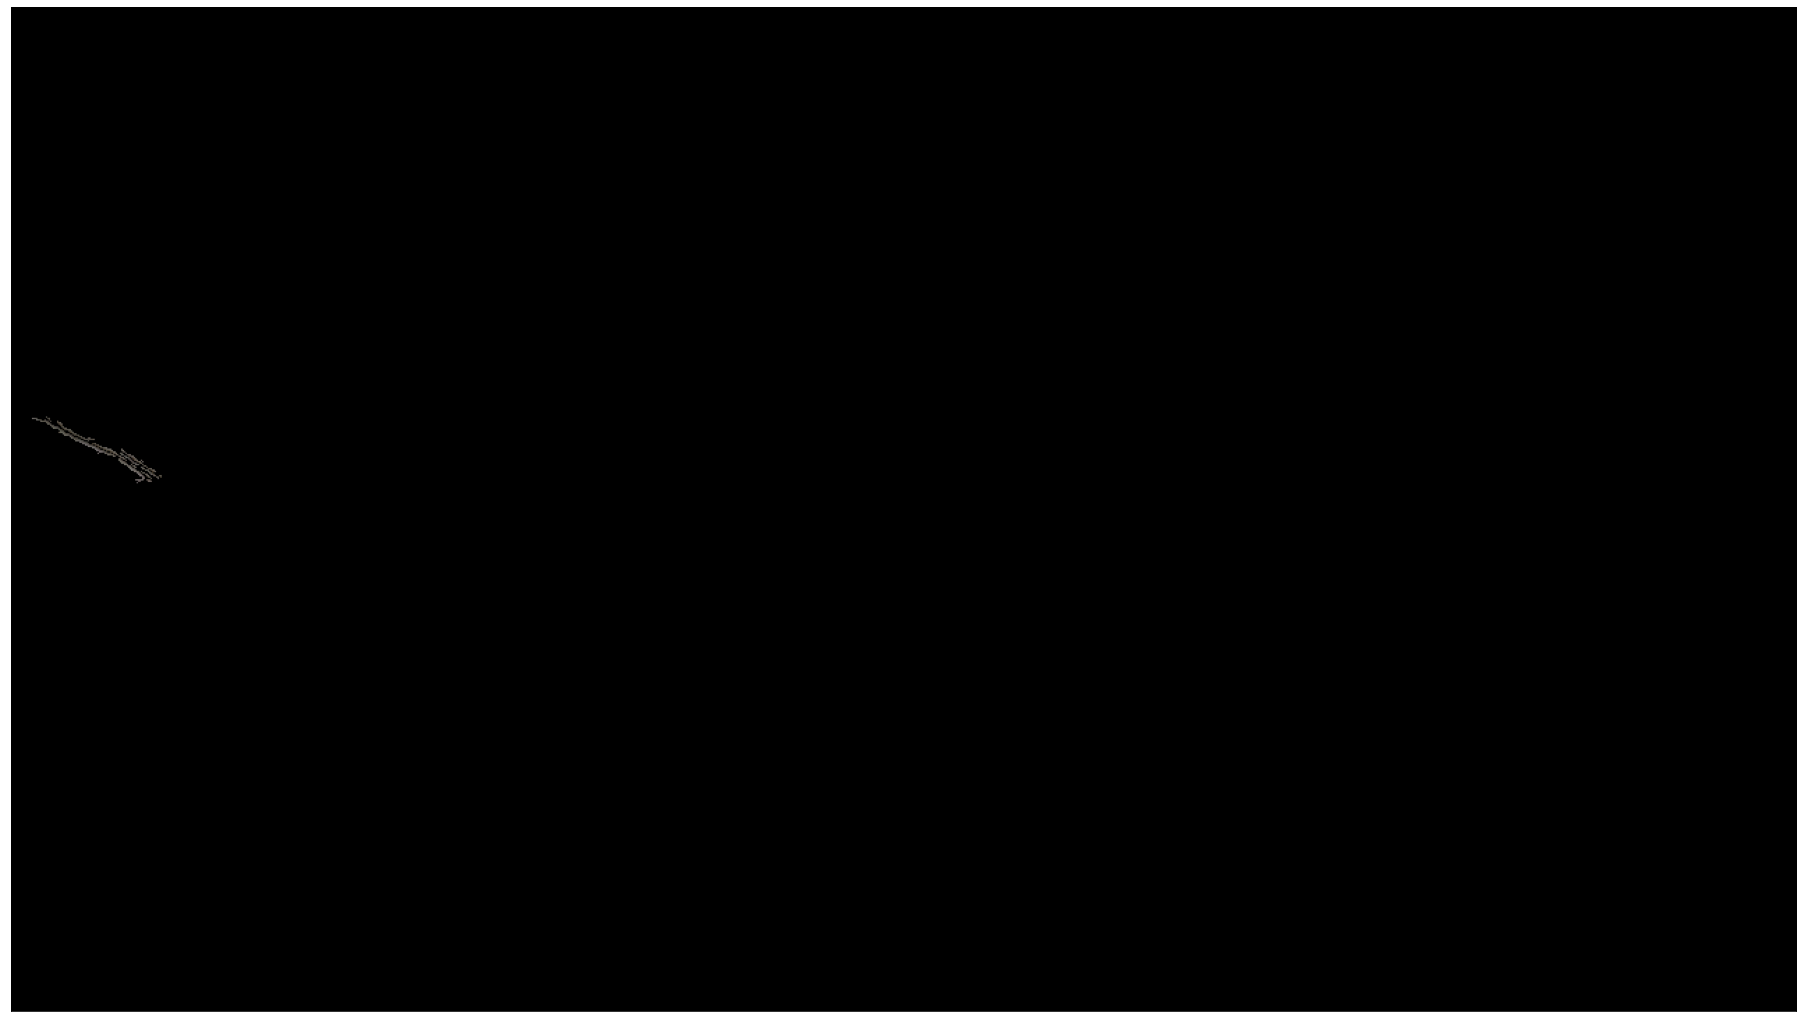

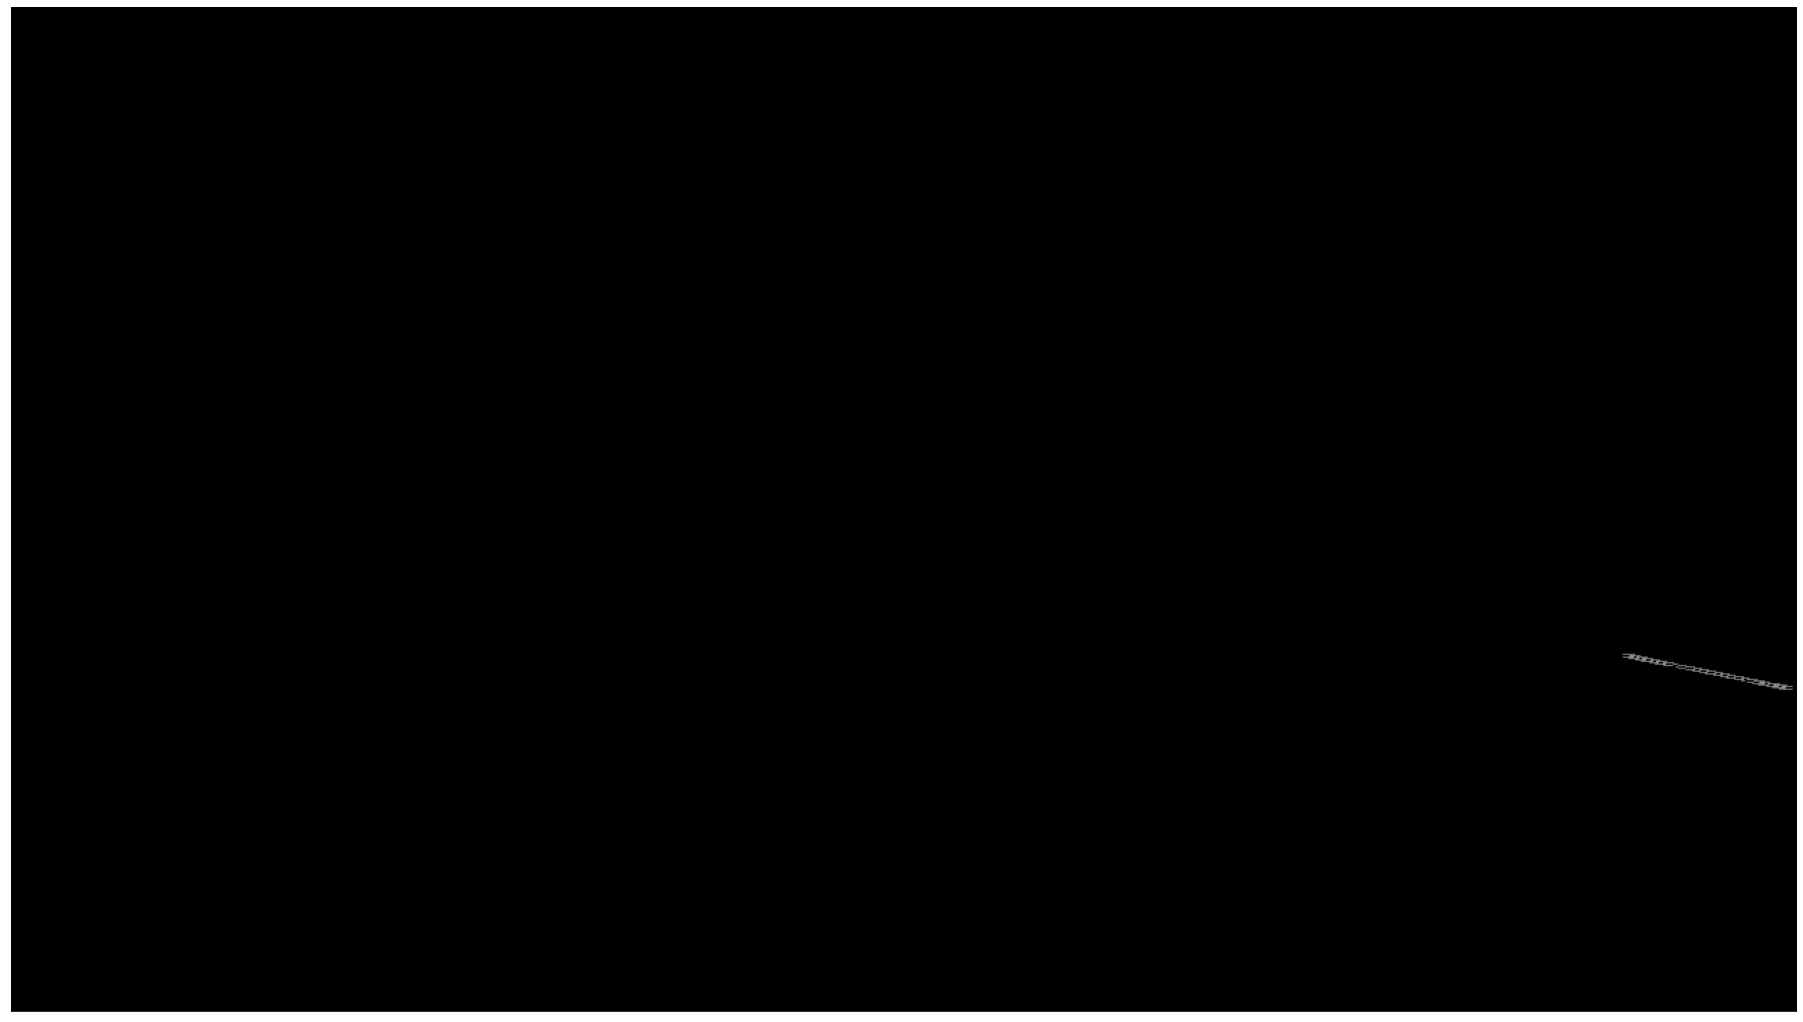

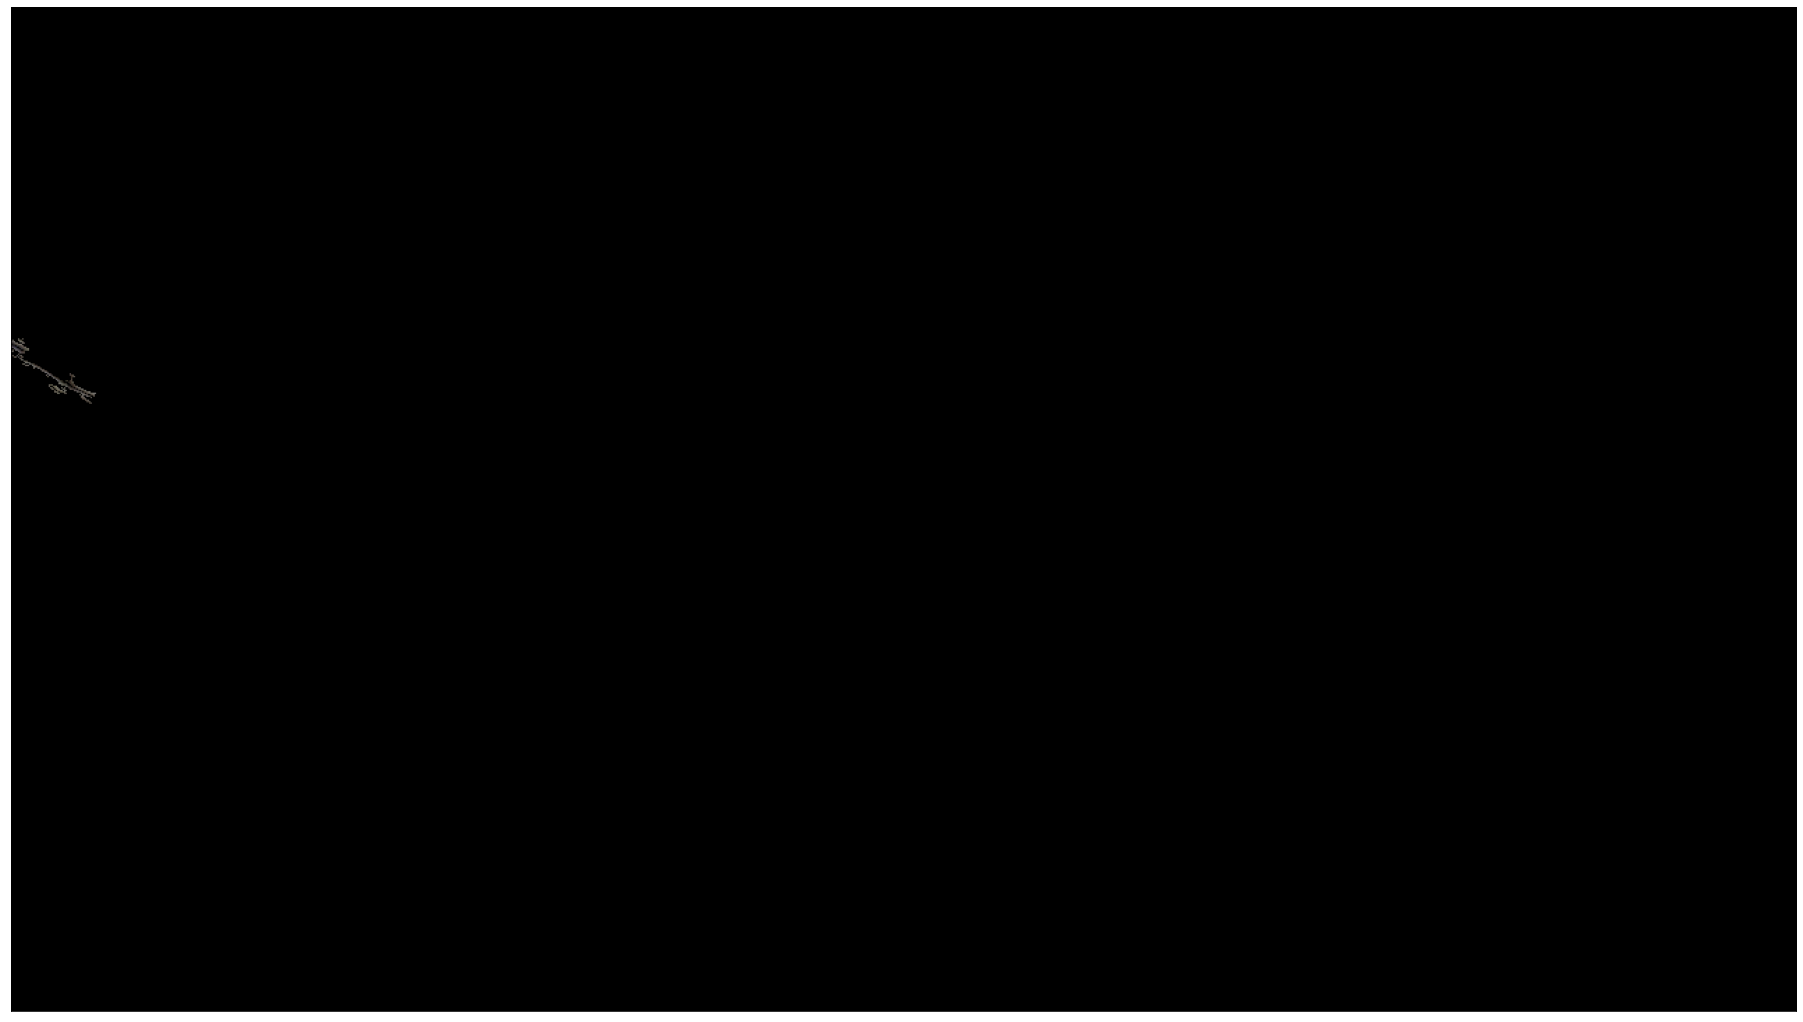

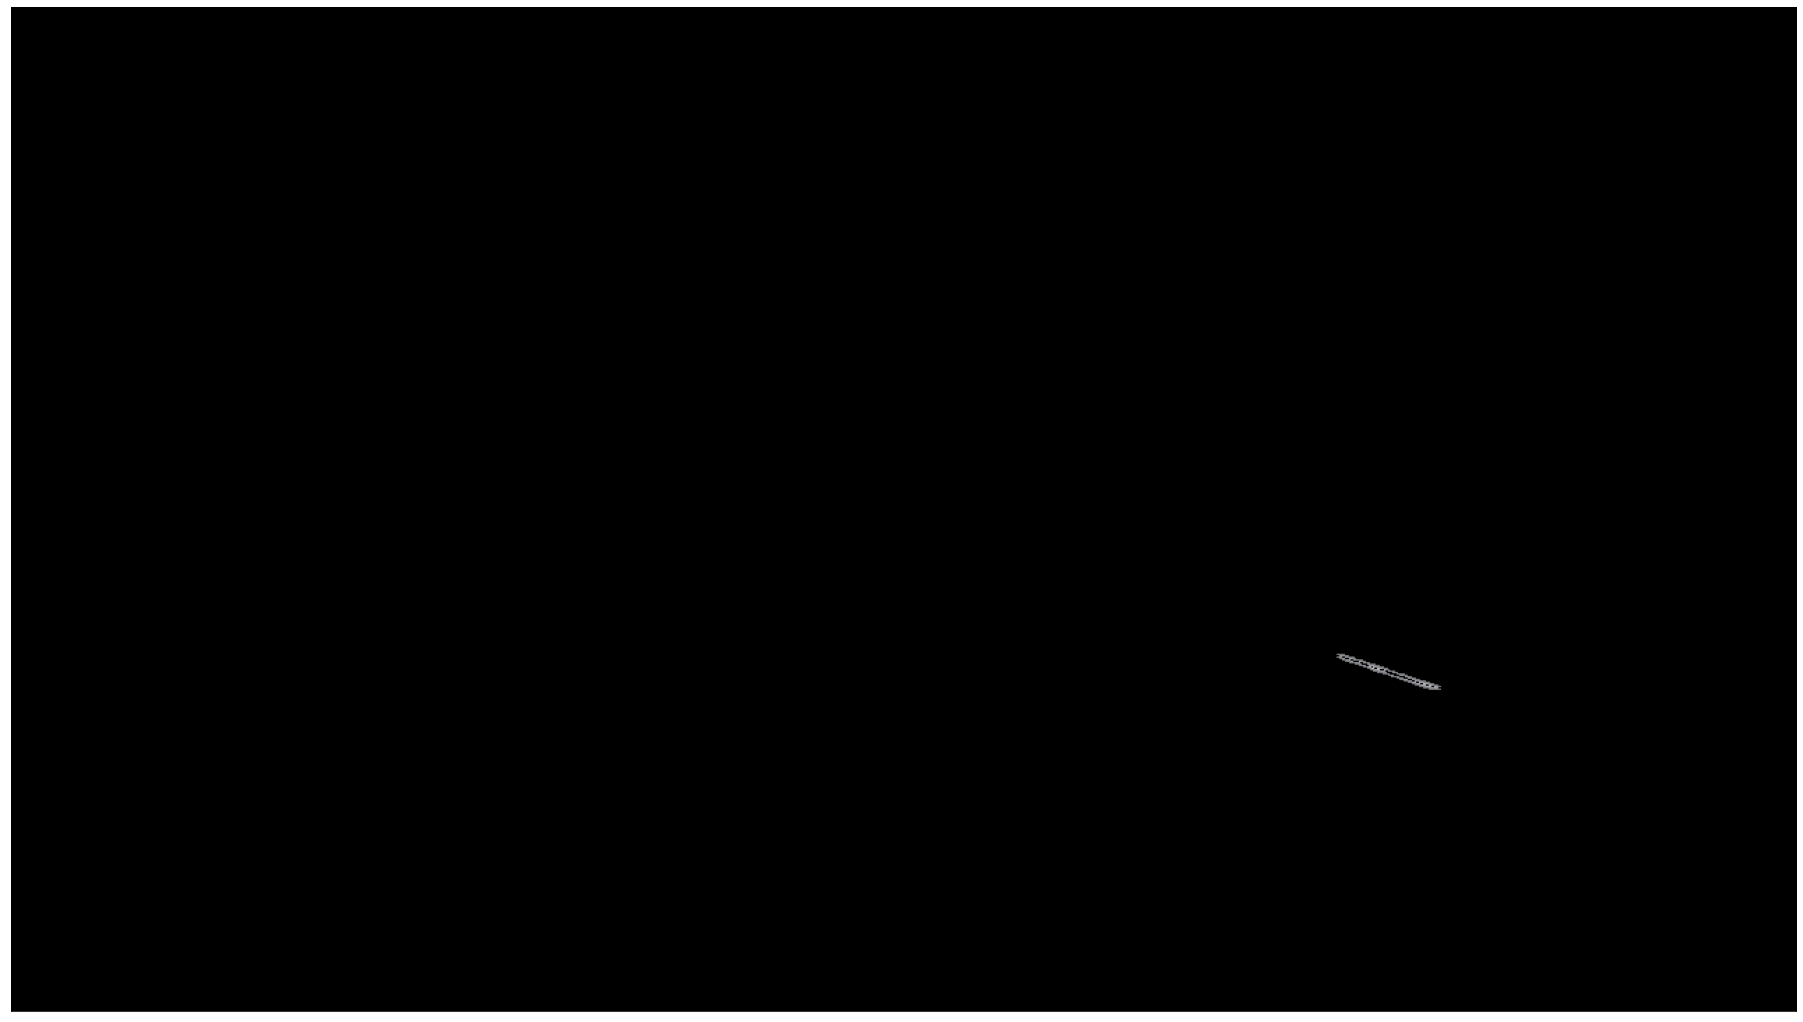

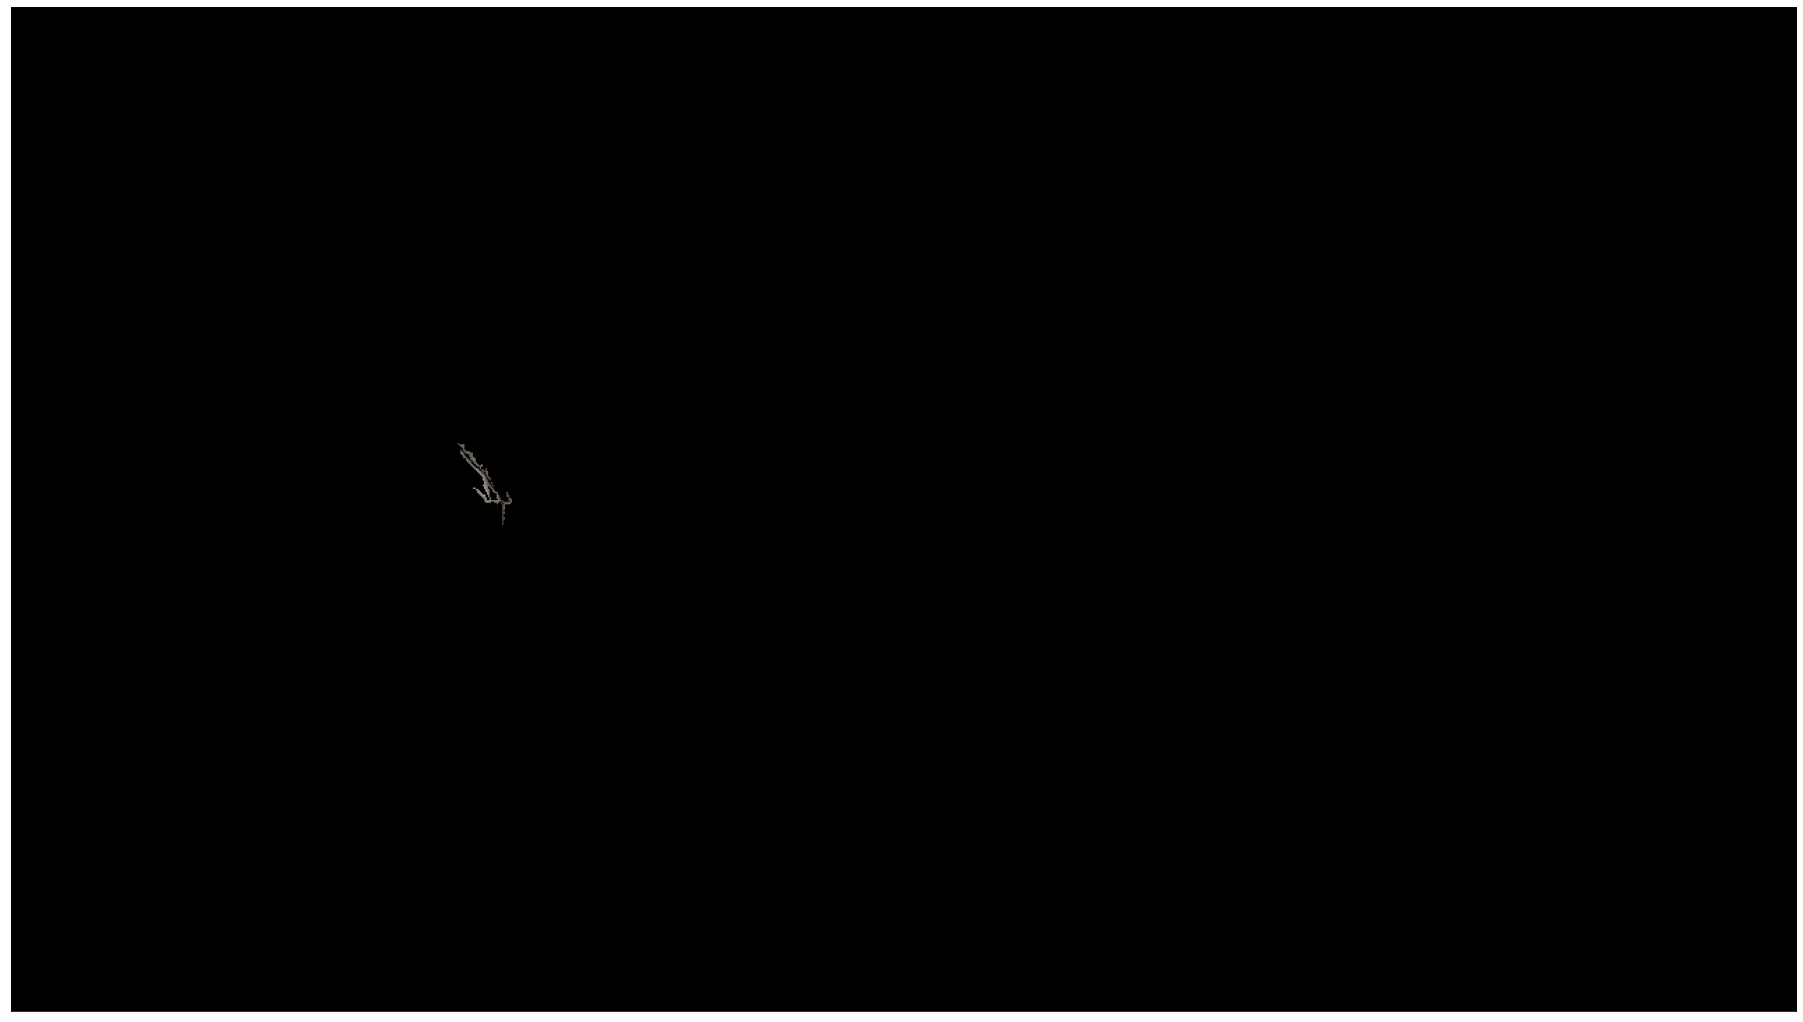

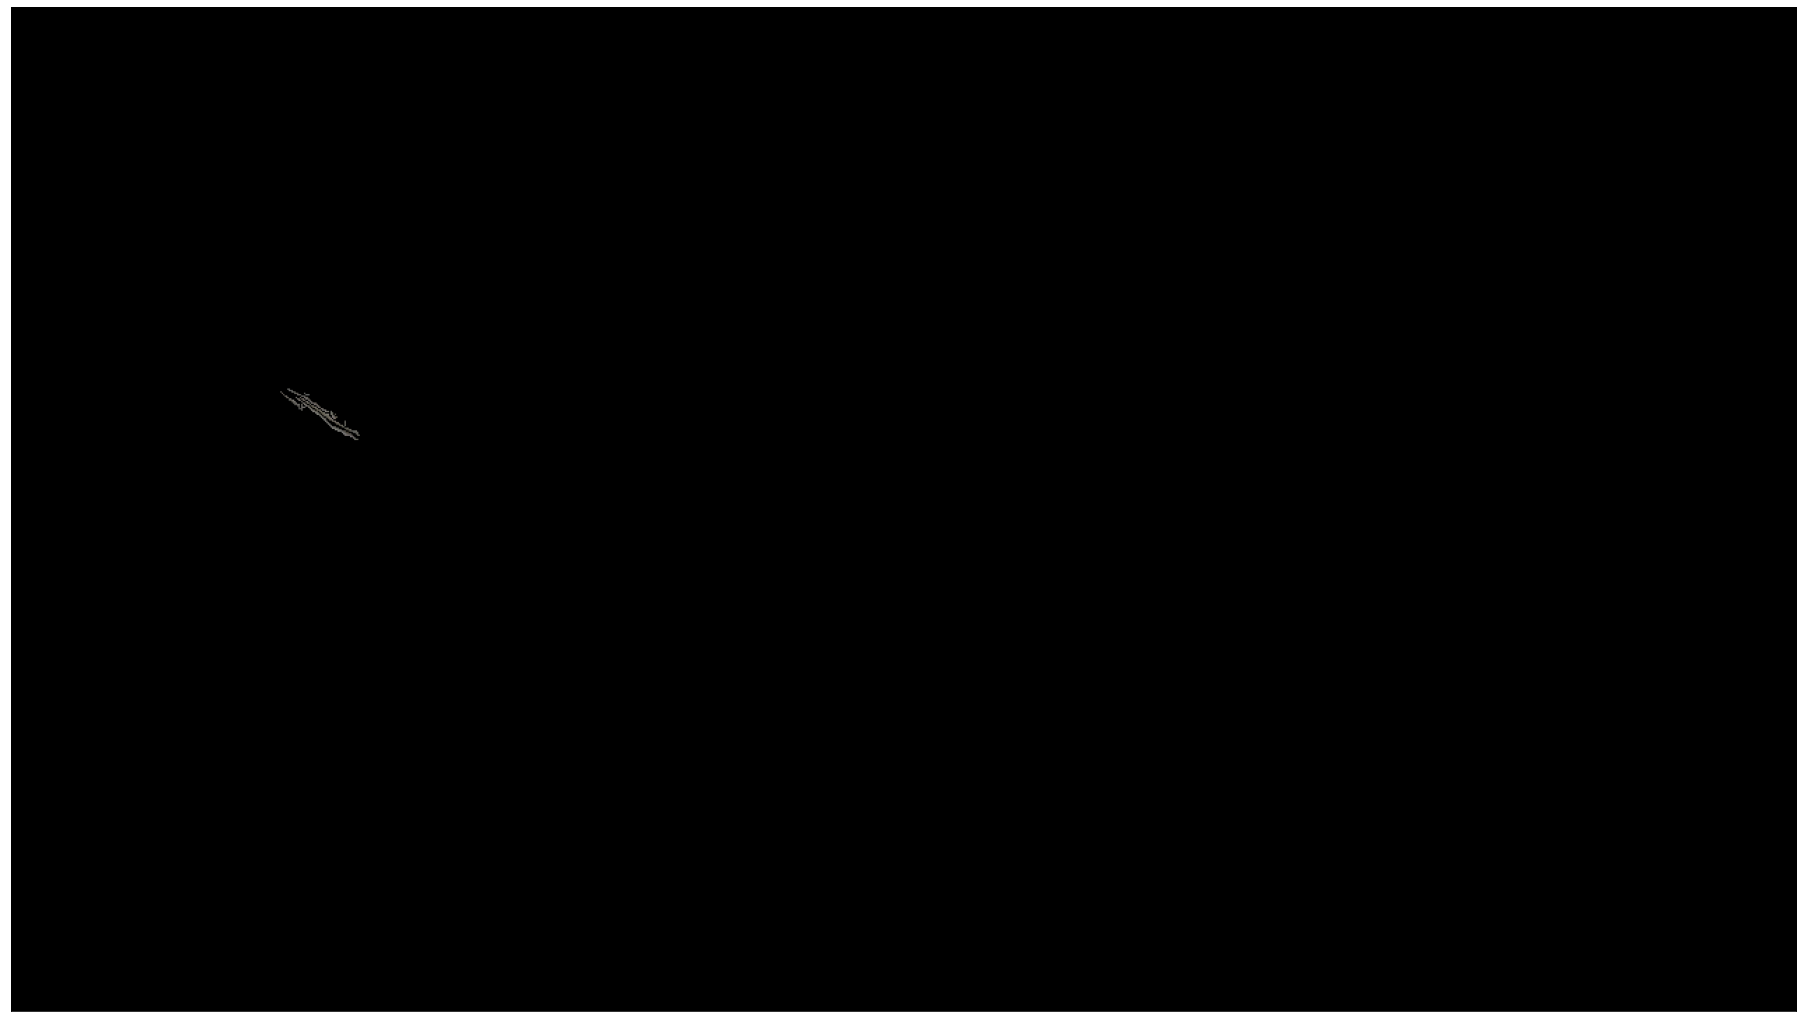

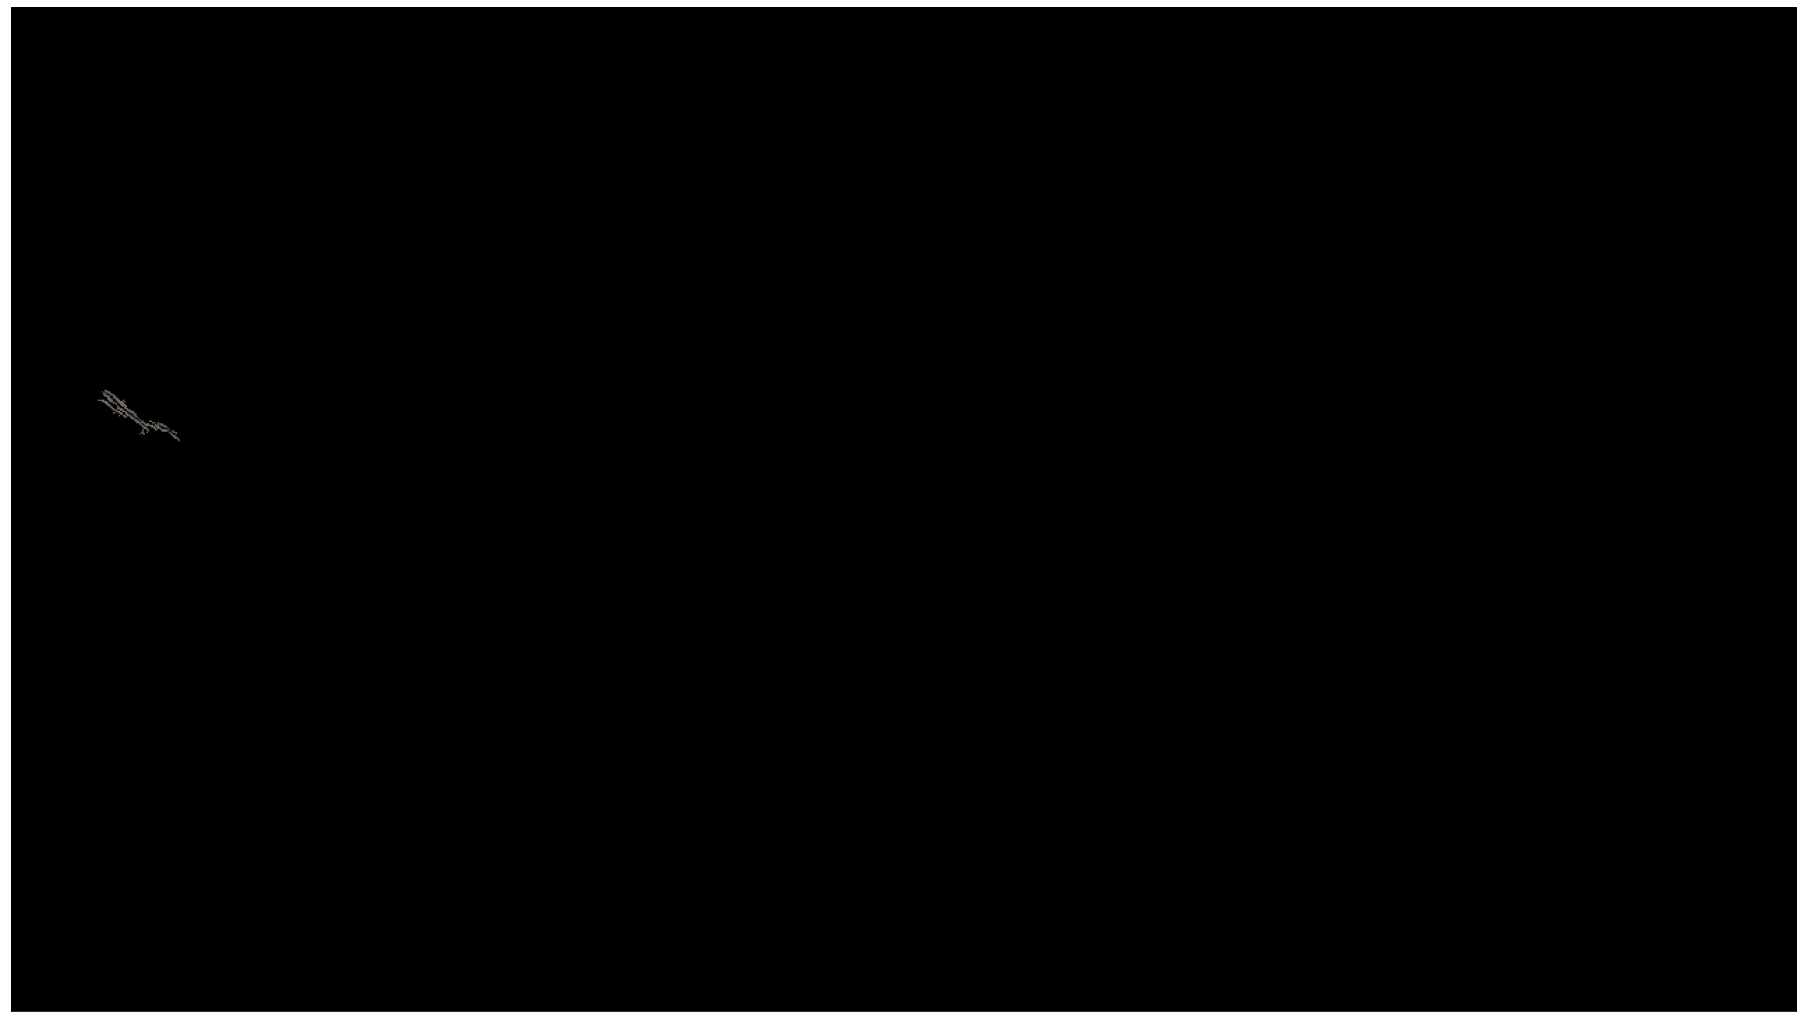

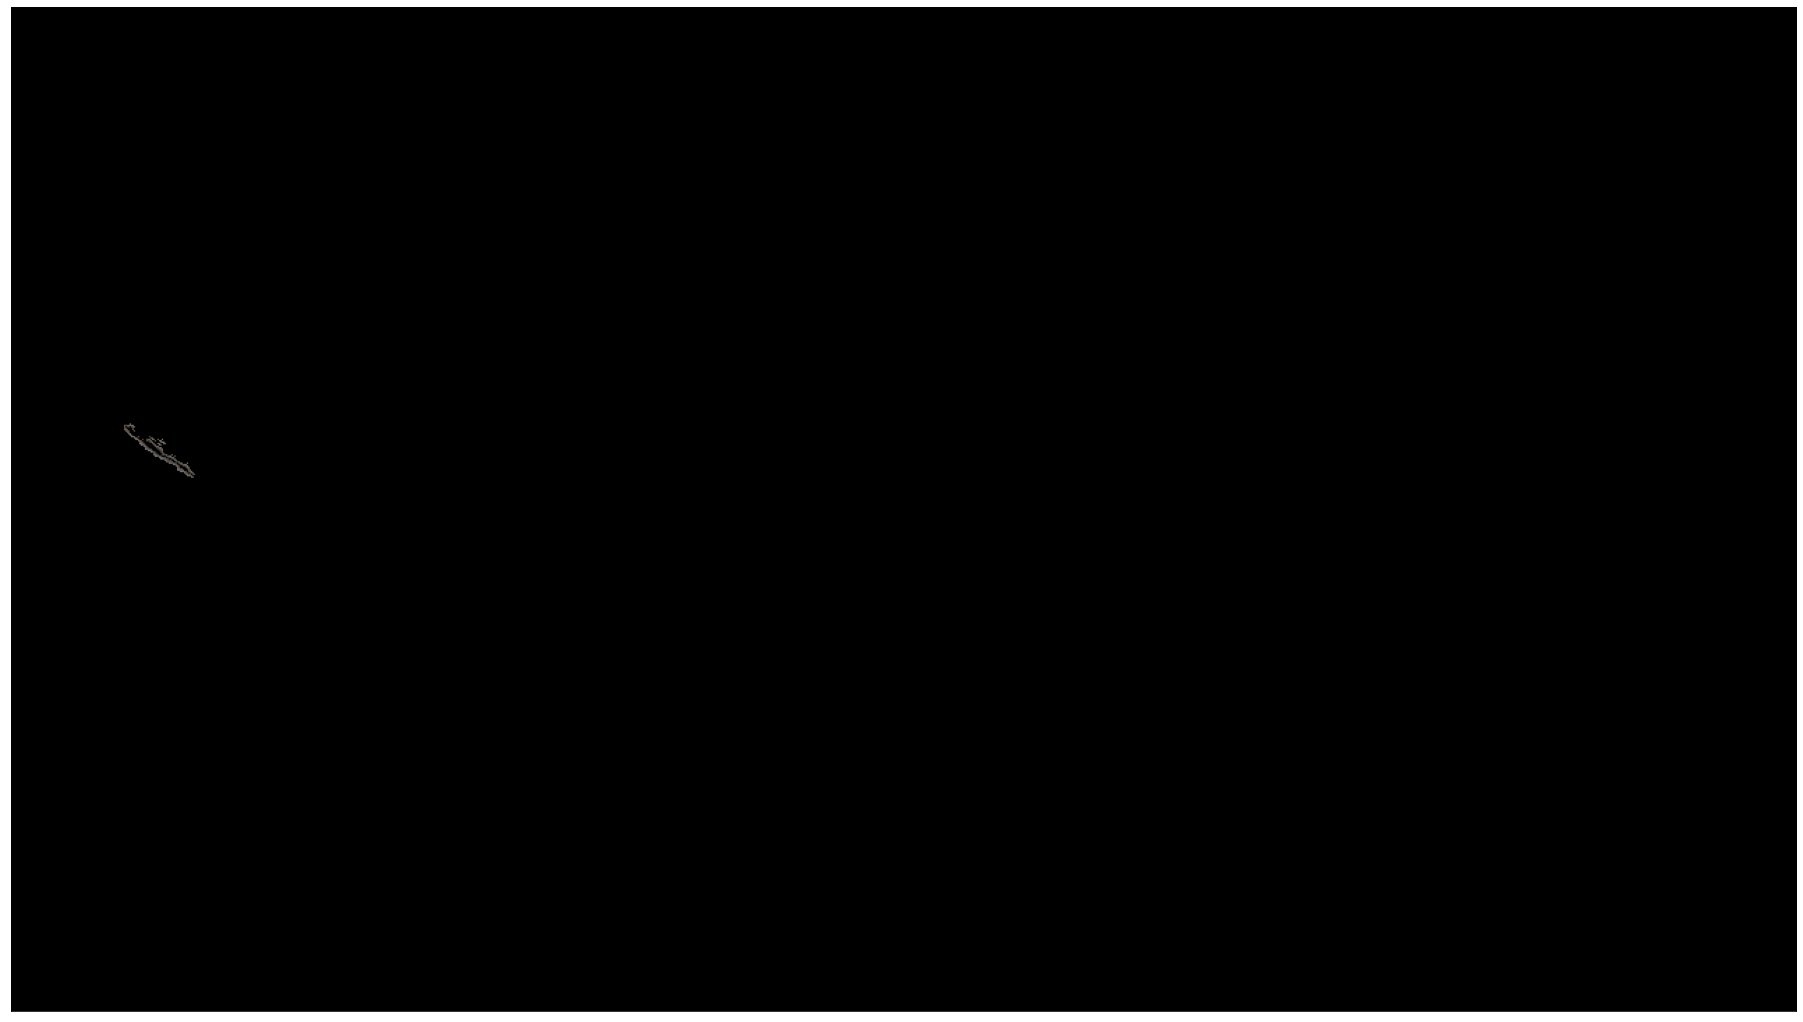

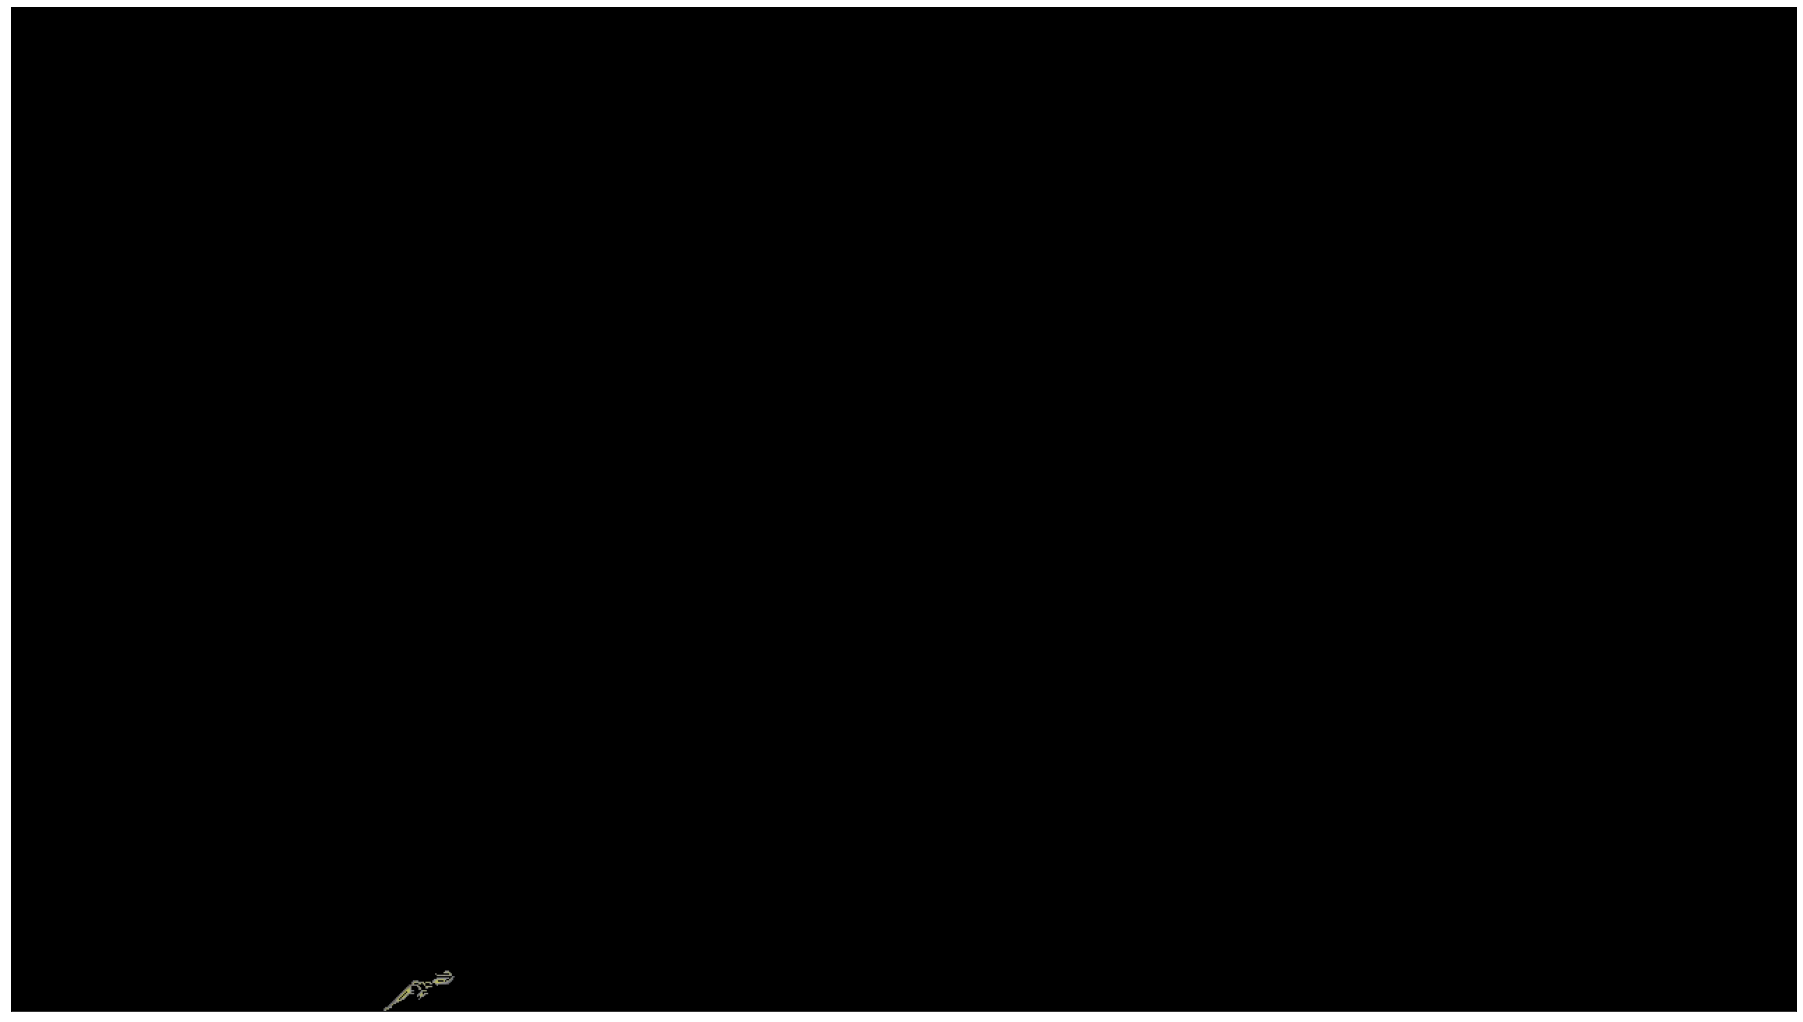

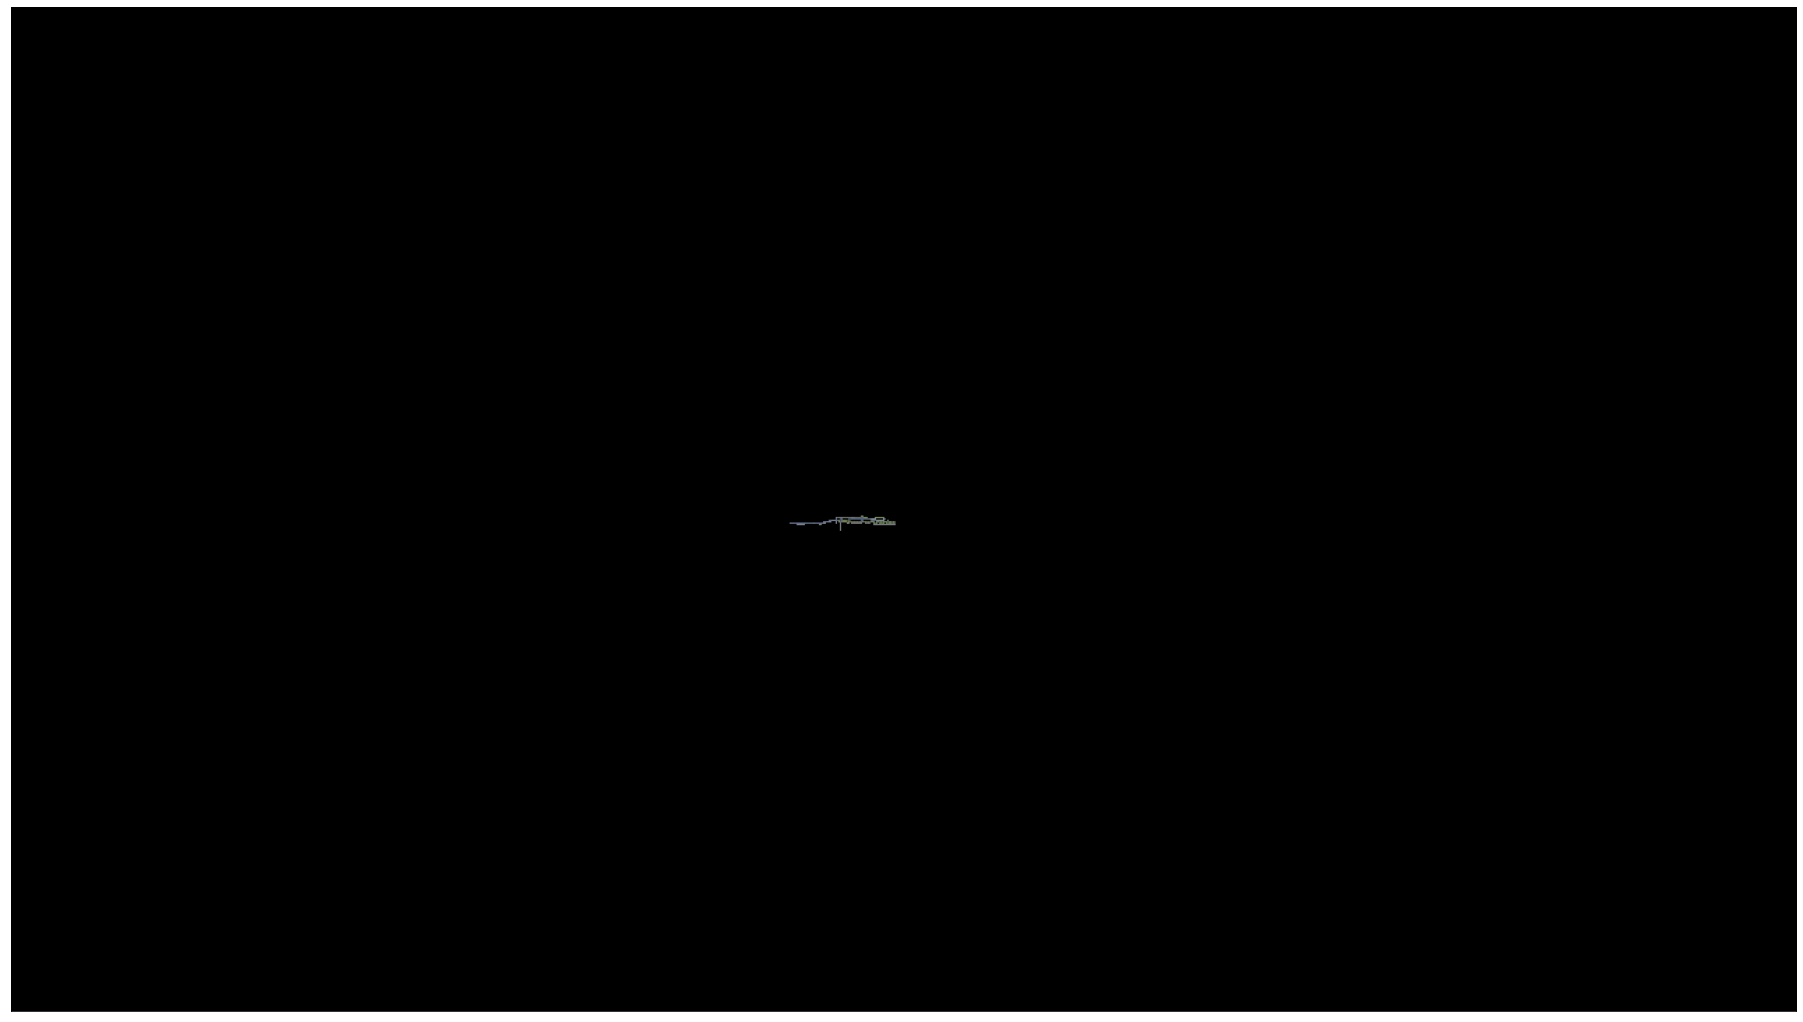

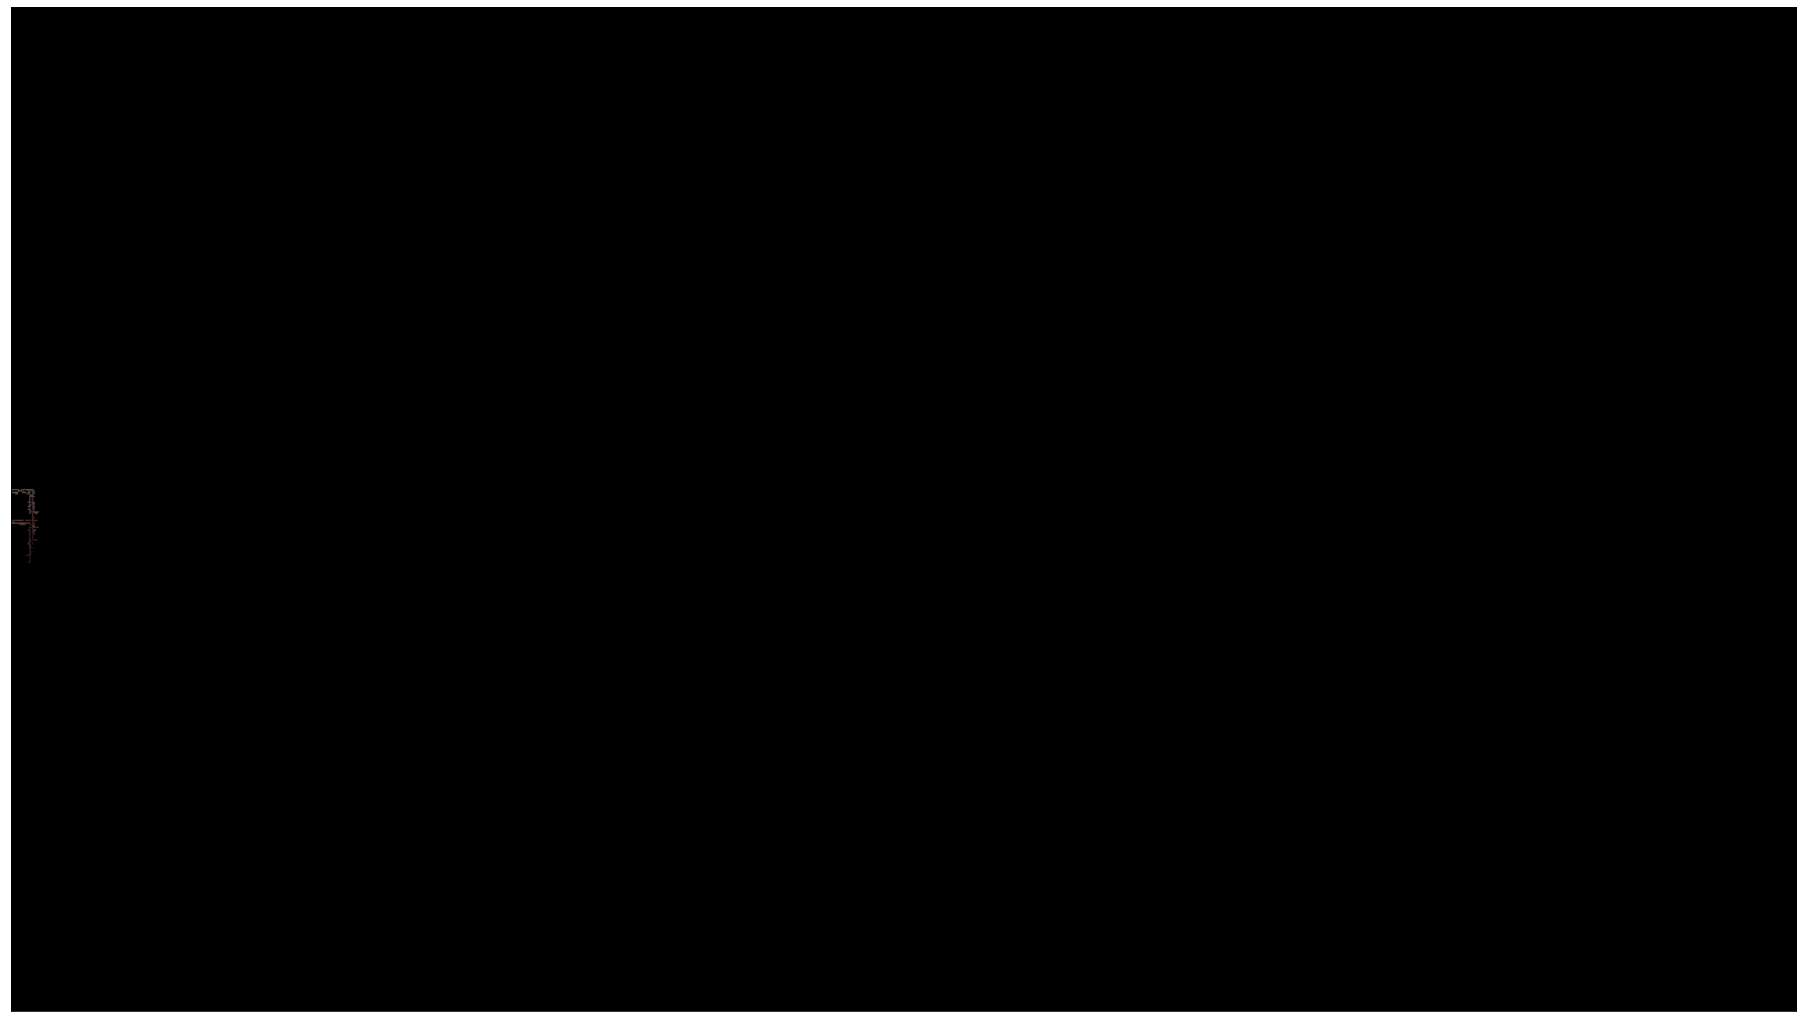

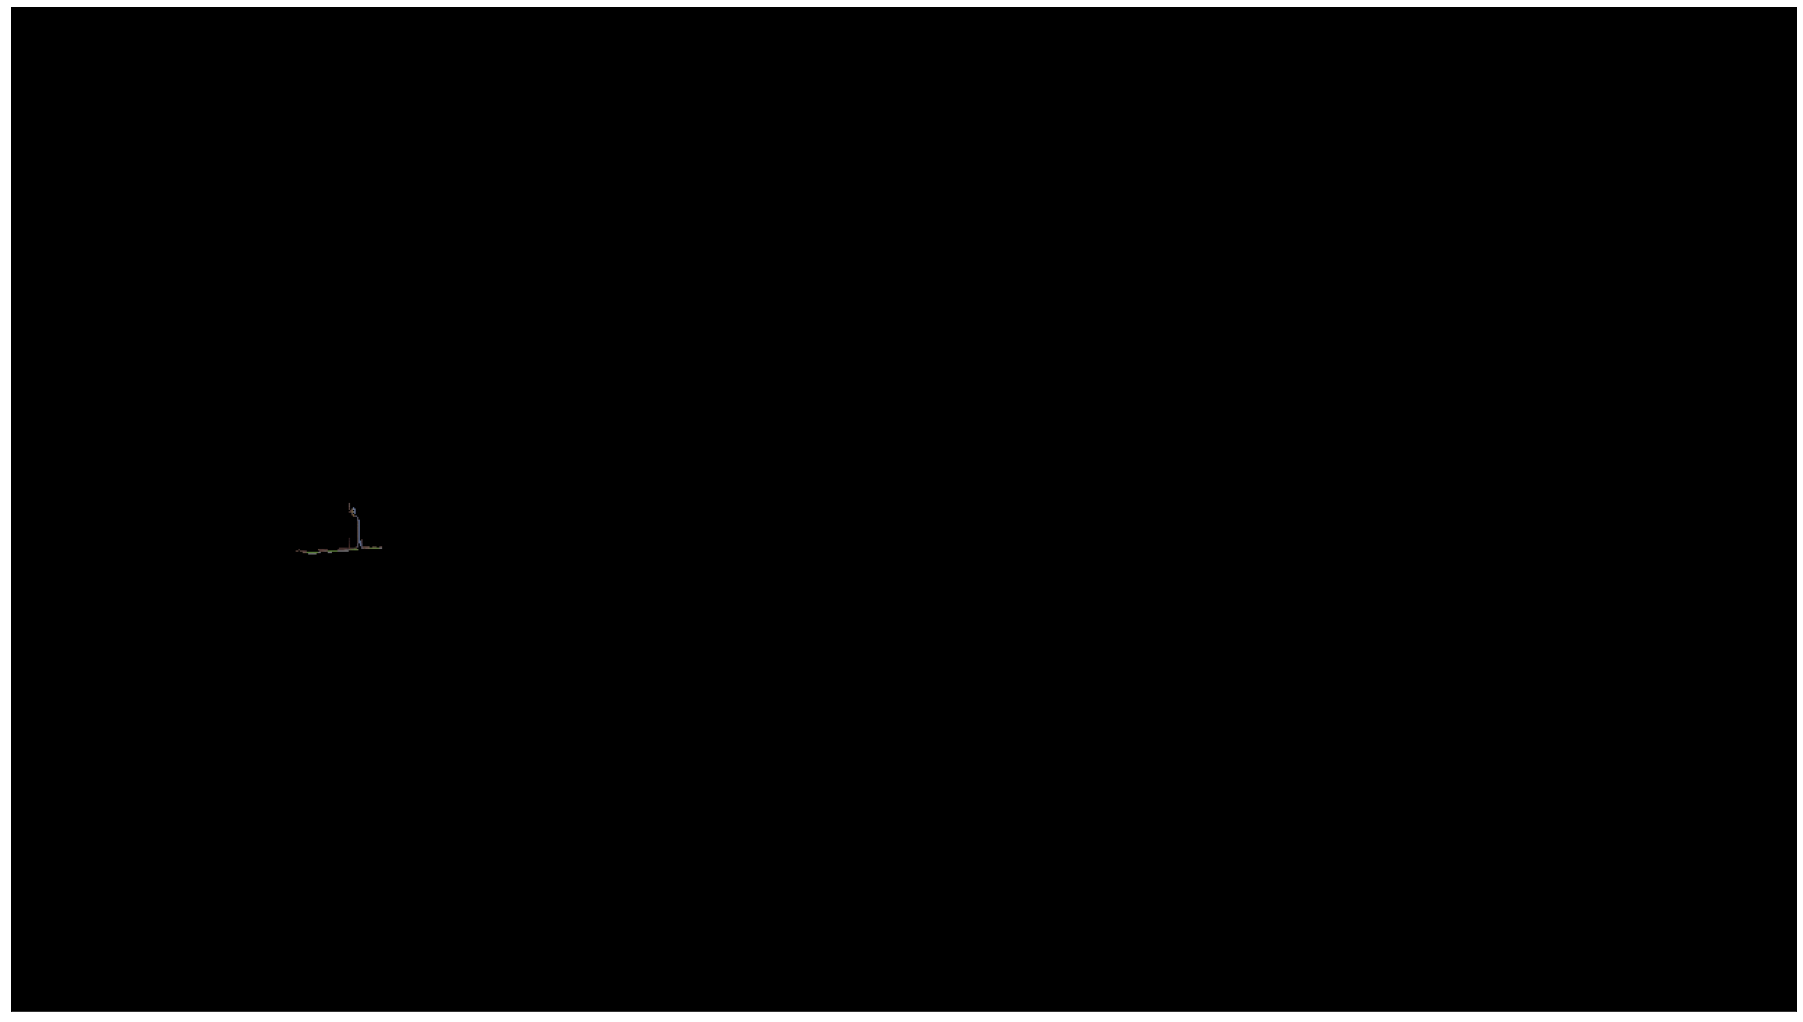

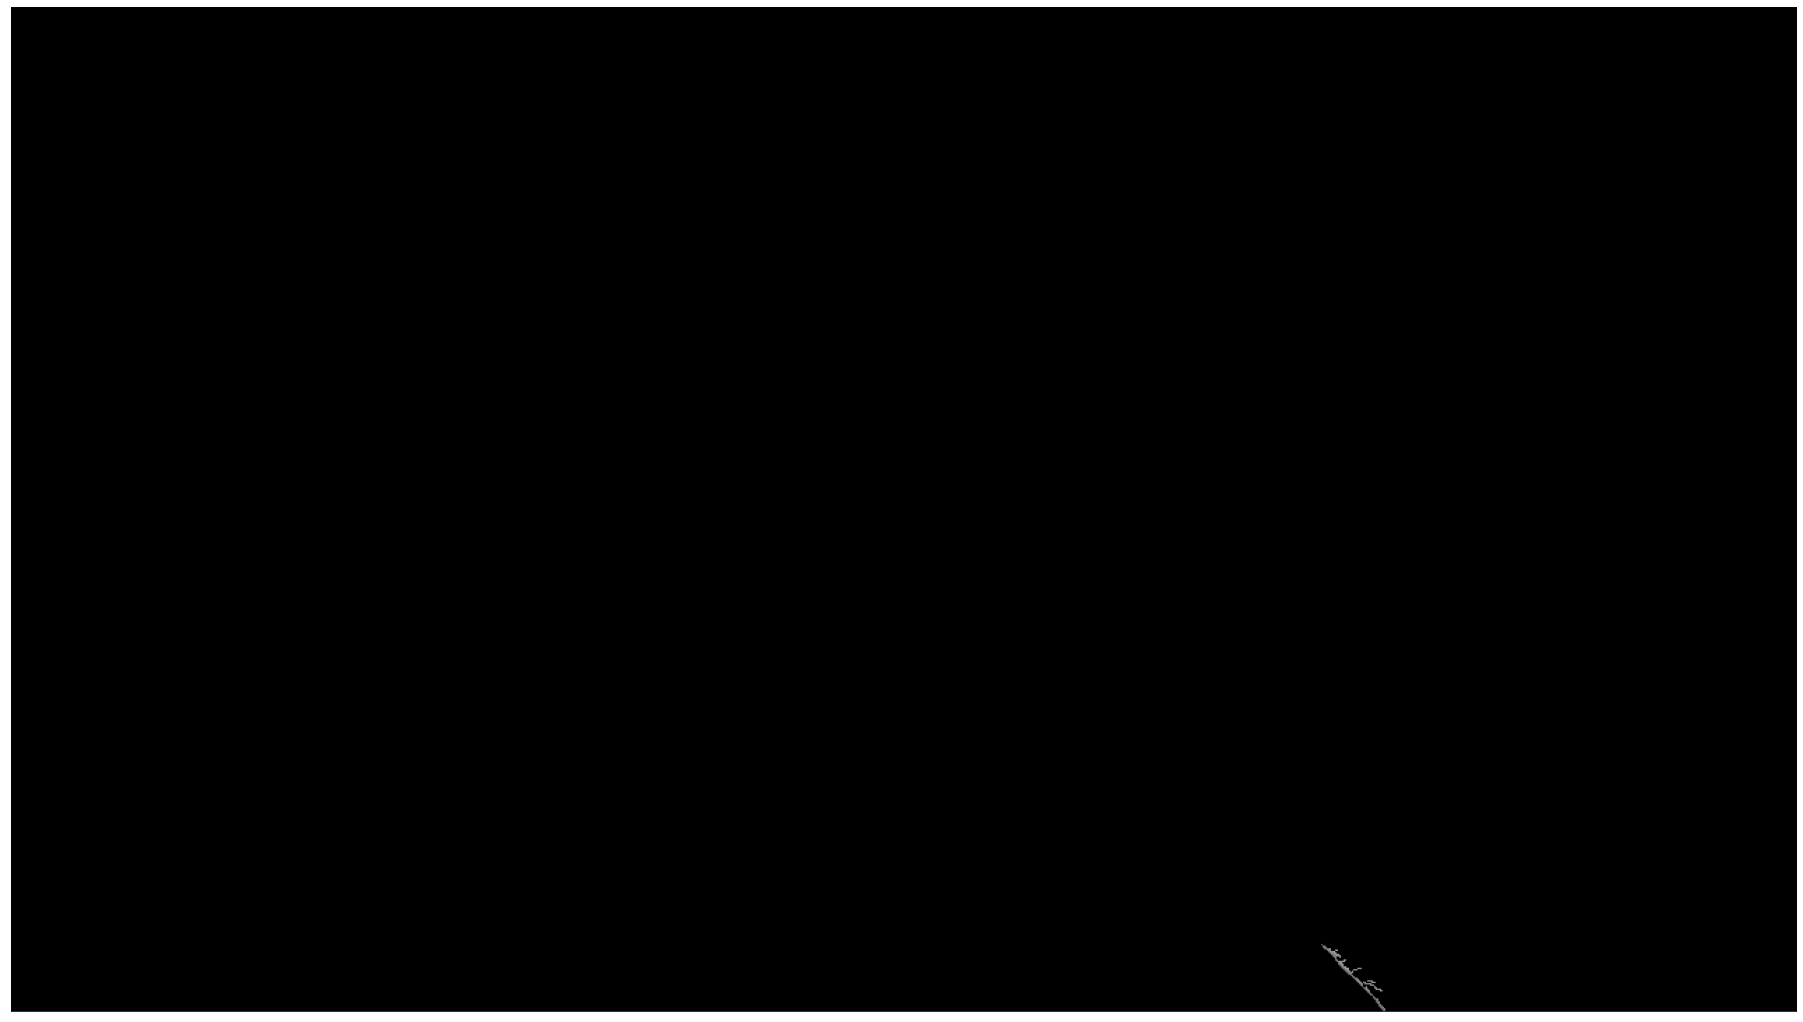

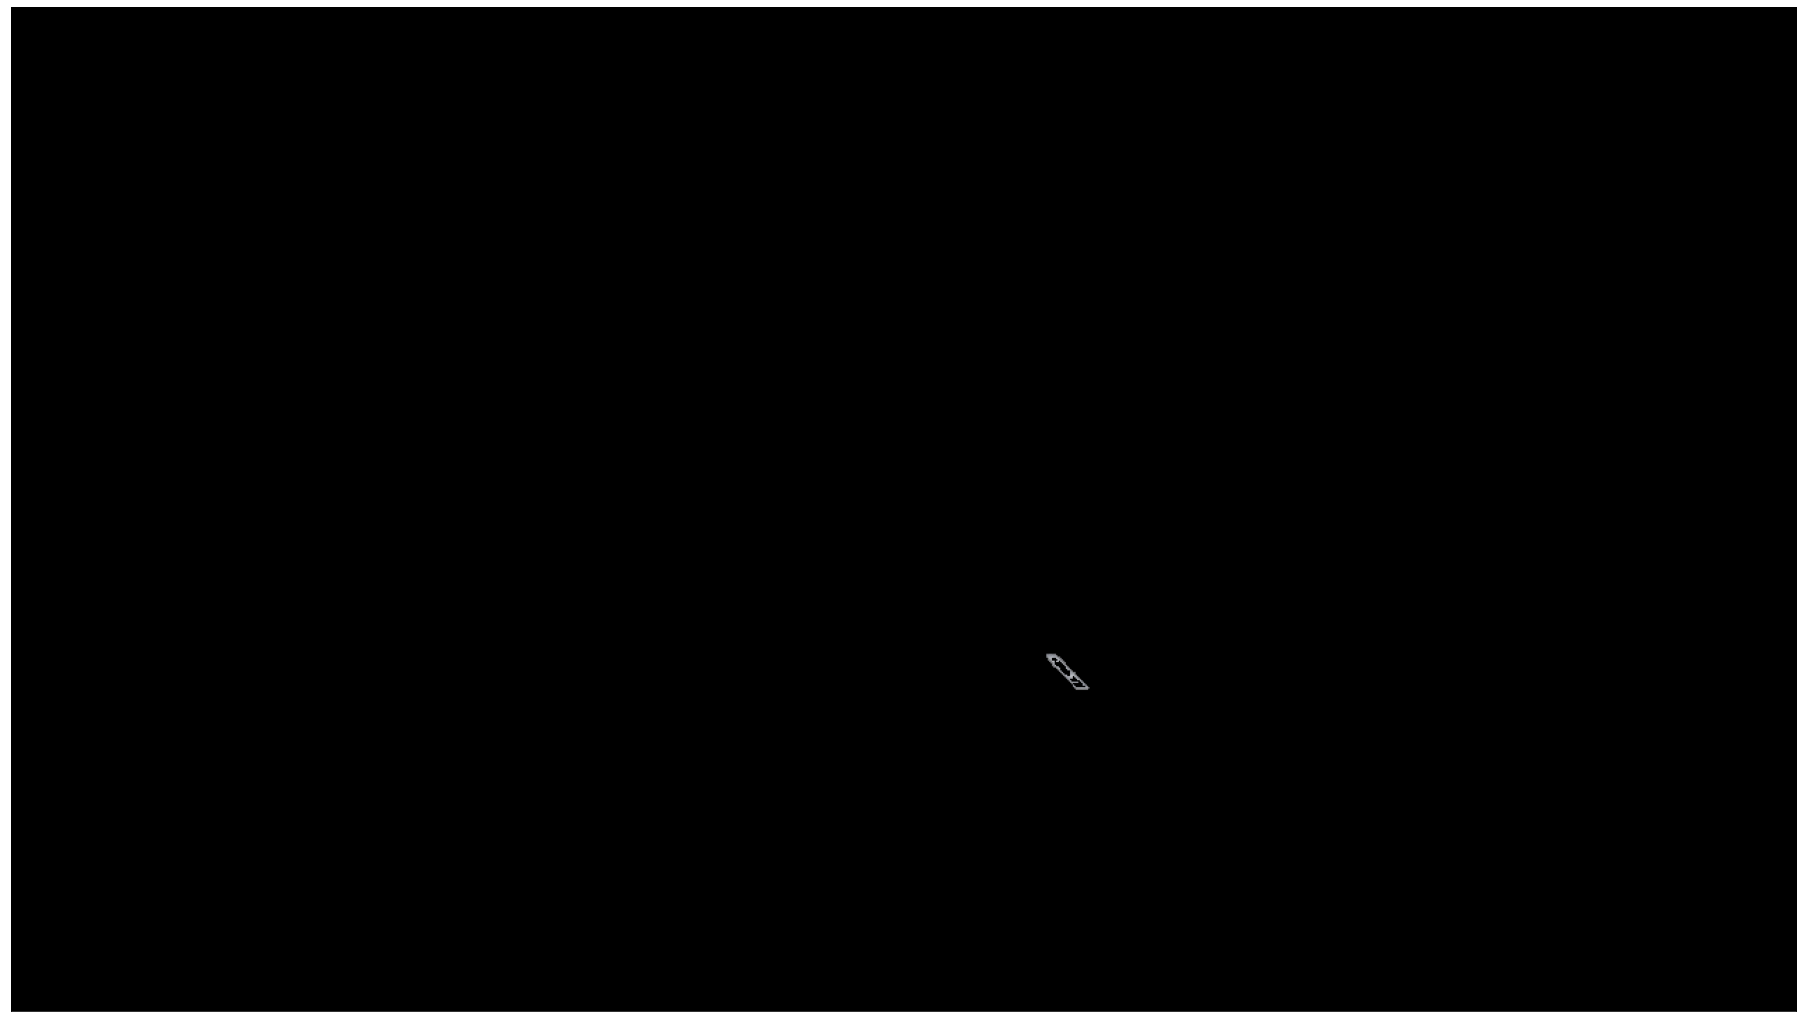

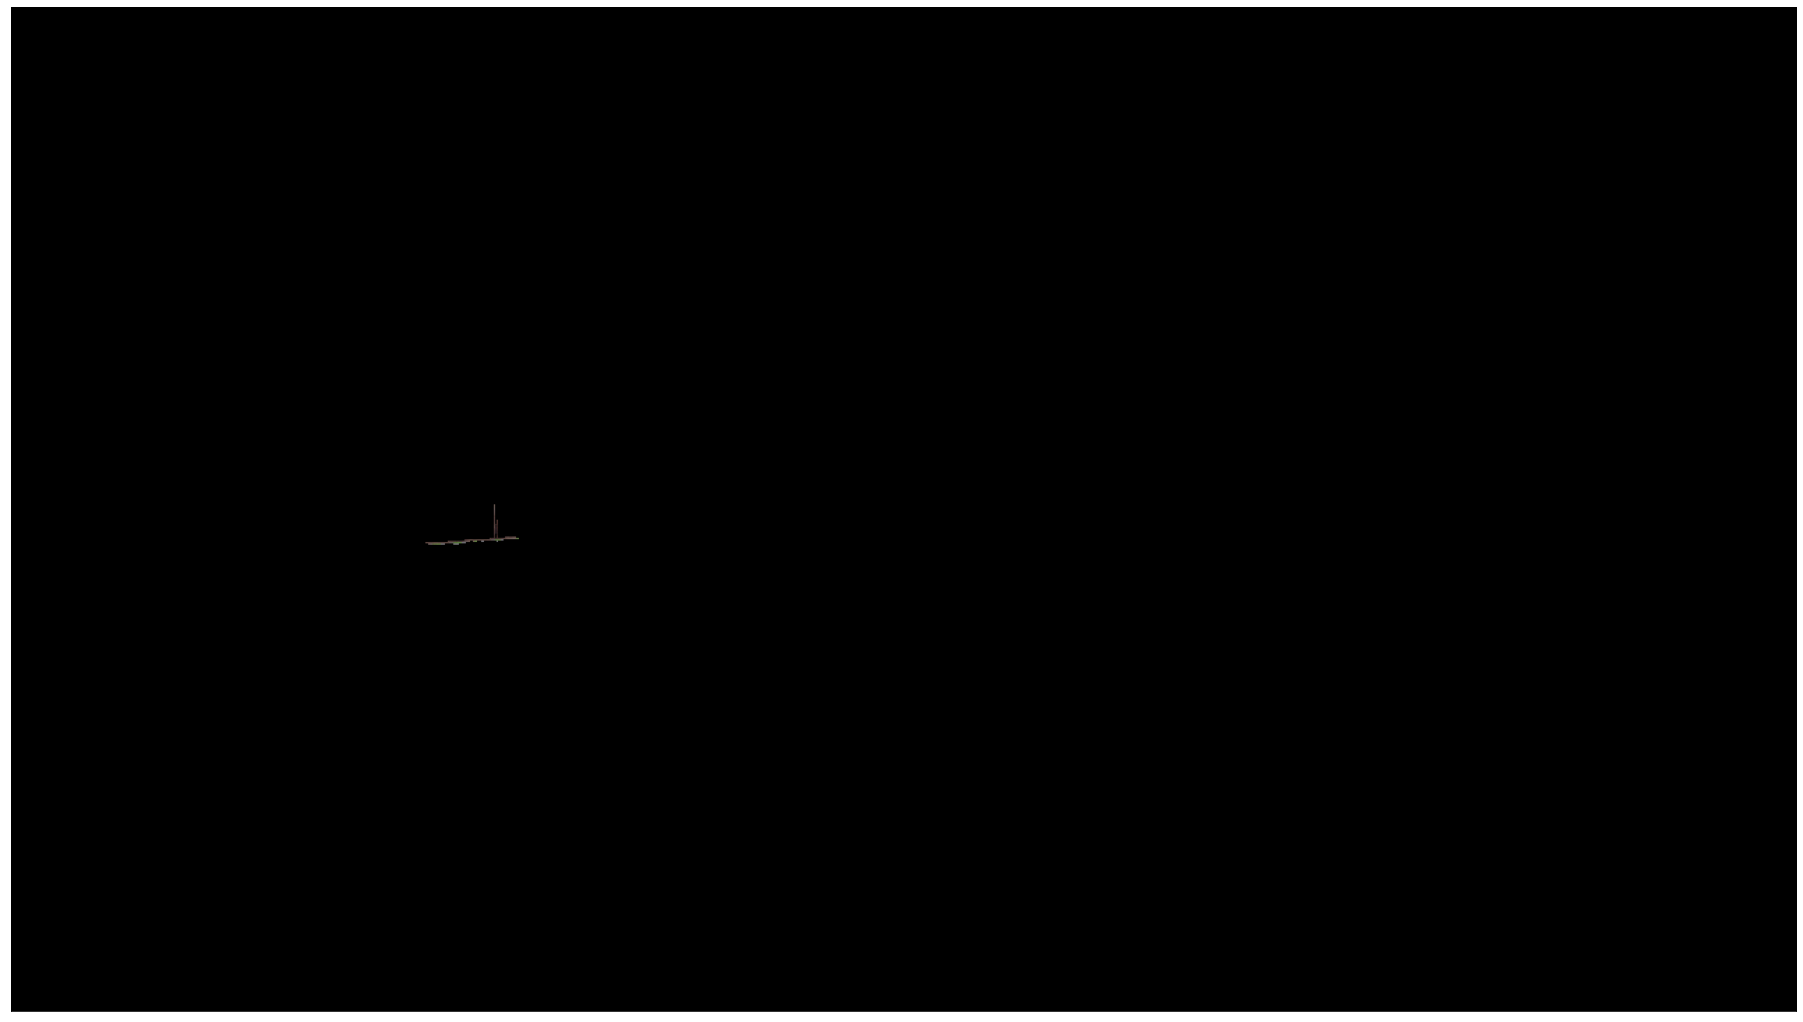

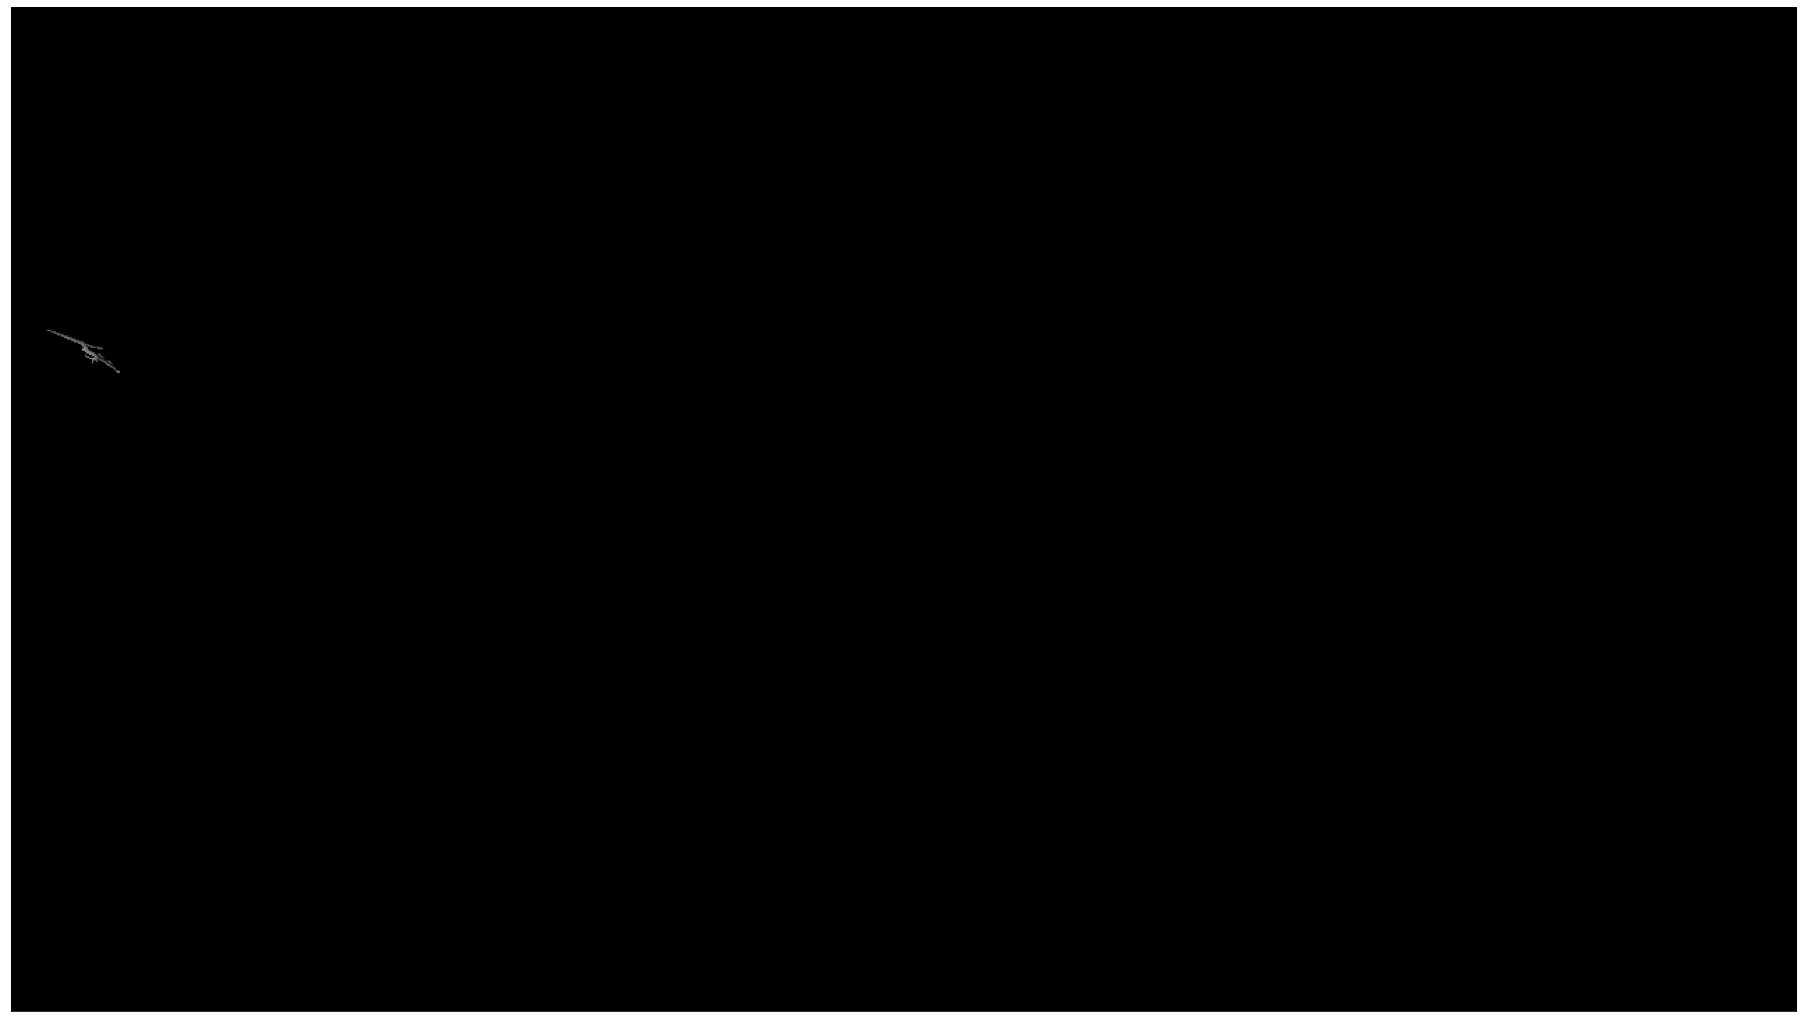

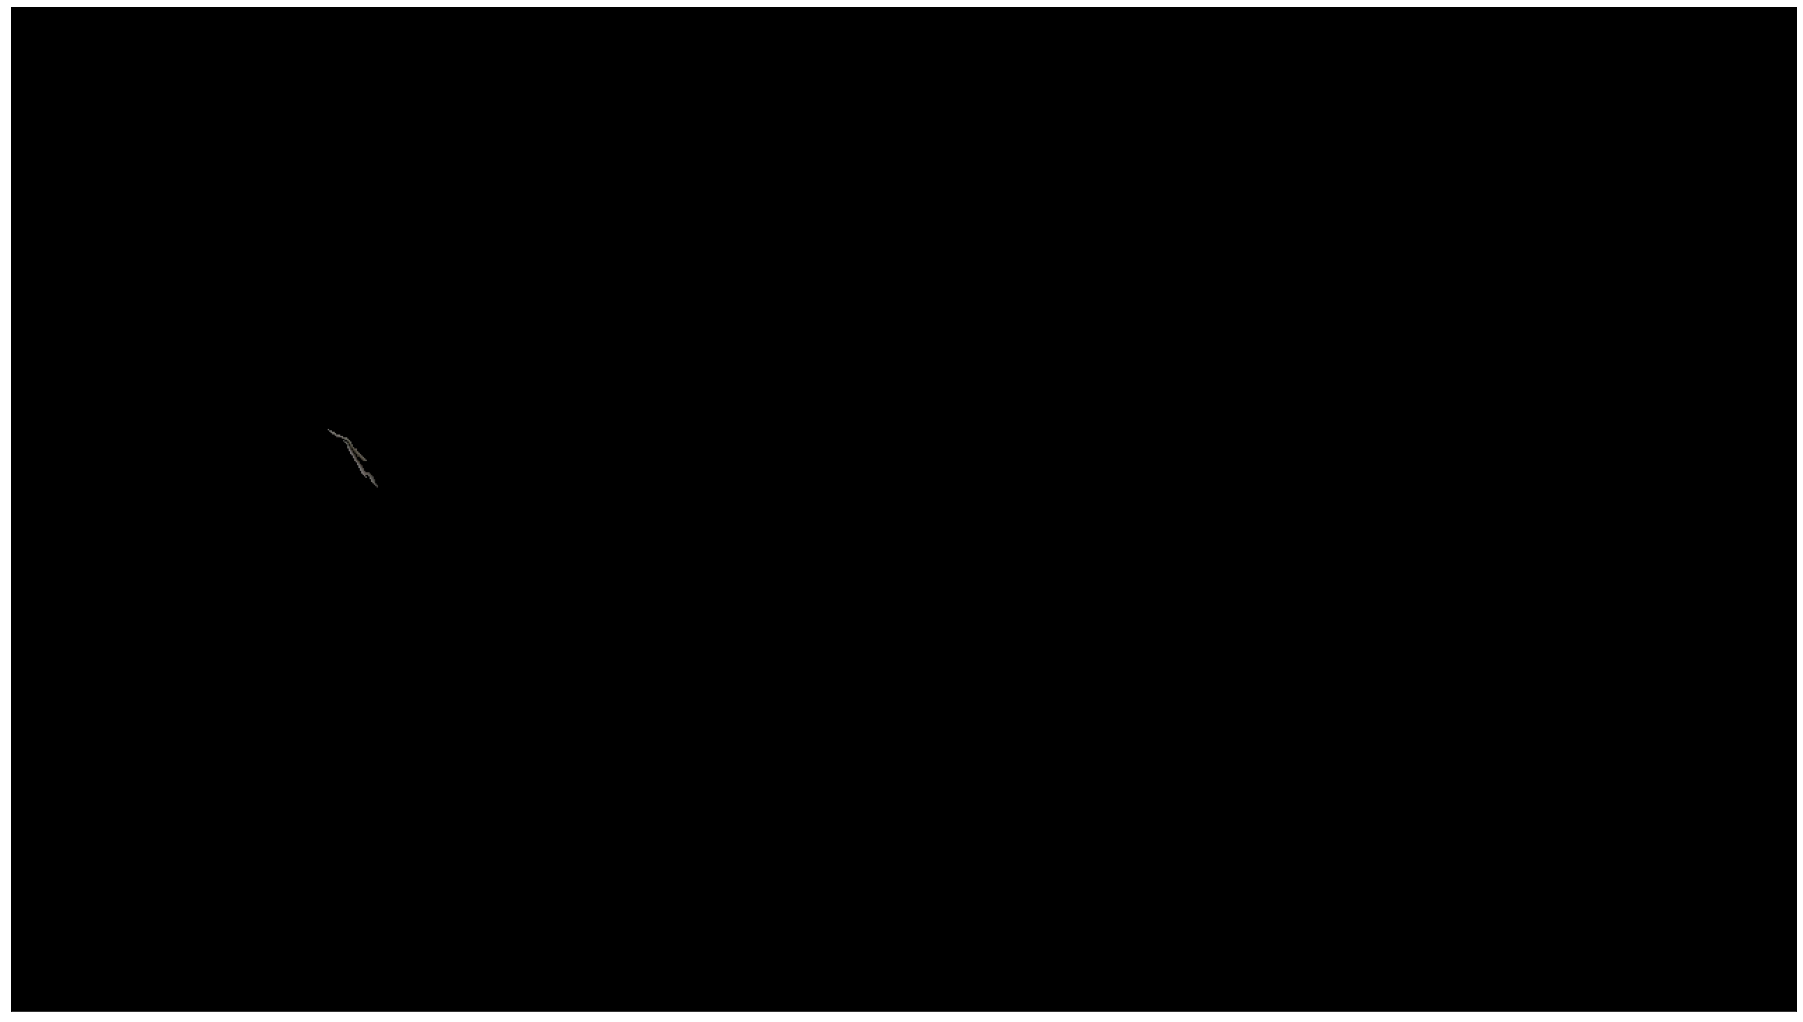

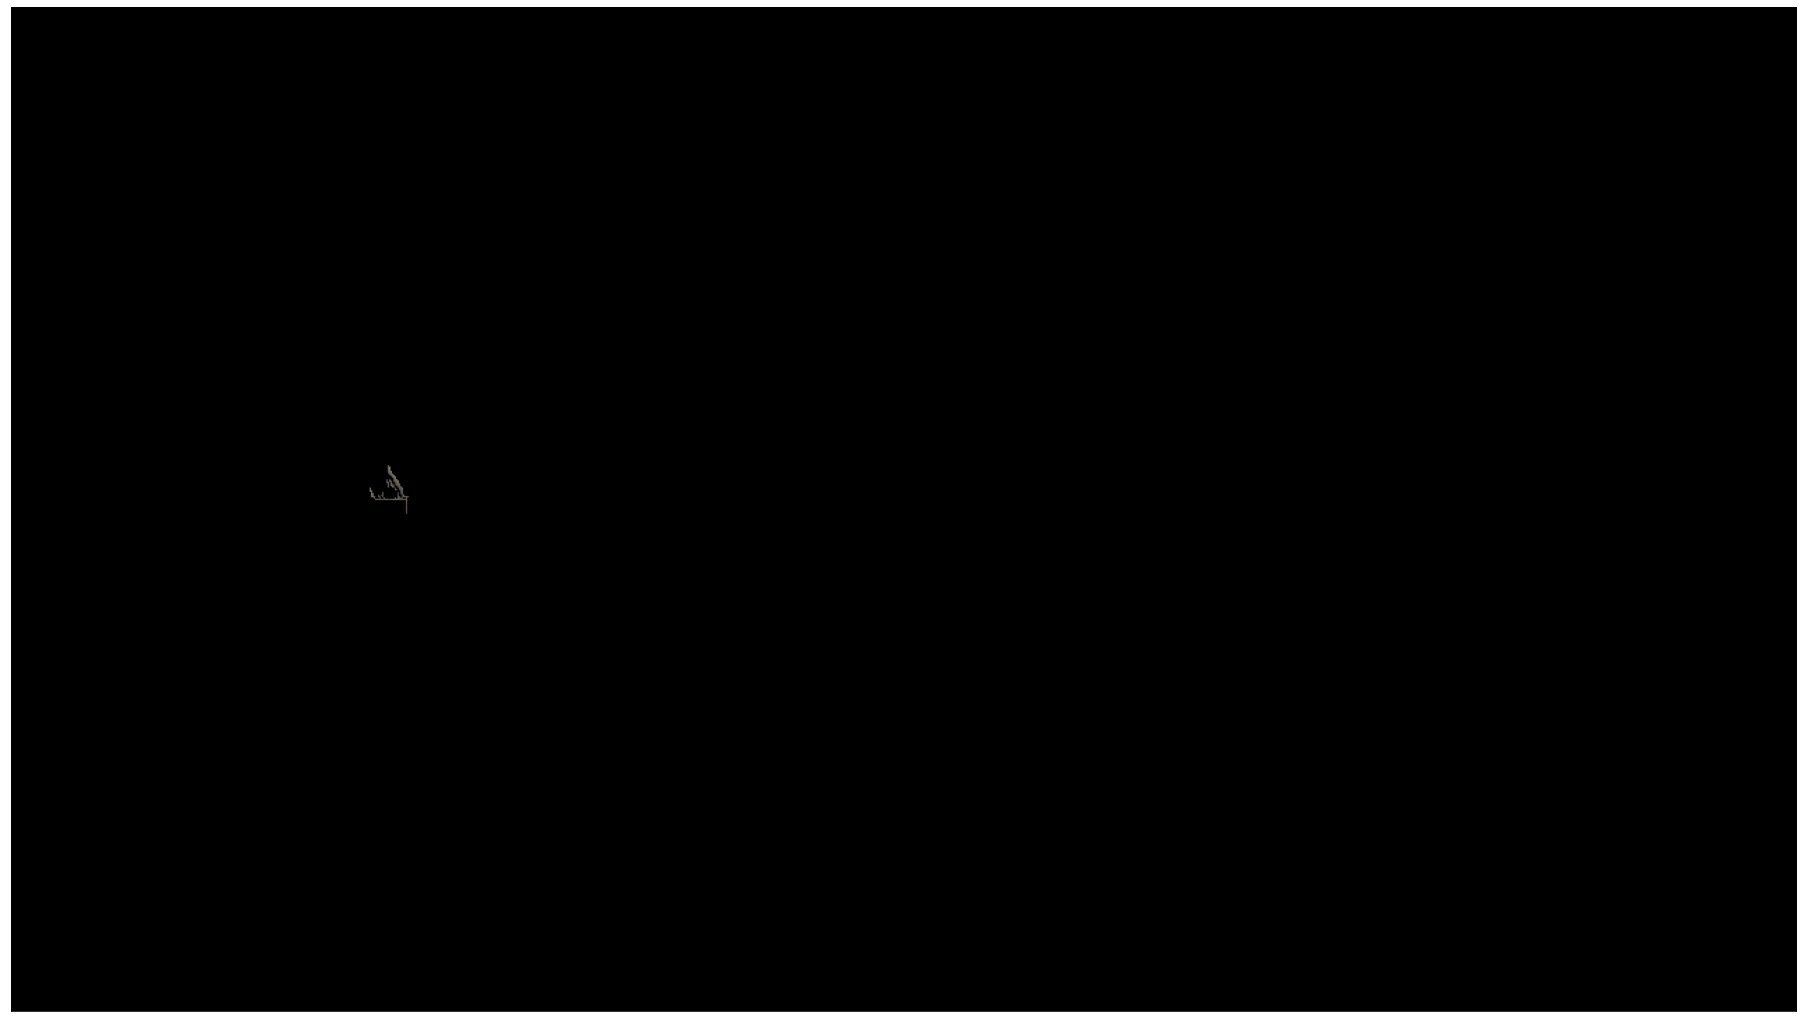

In [51]:
plot_img_grid(components, 1, row_height=20)

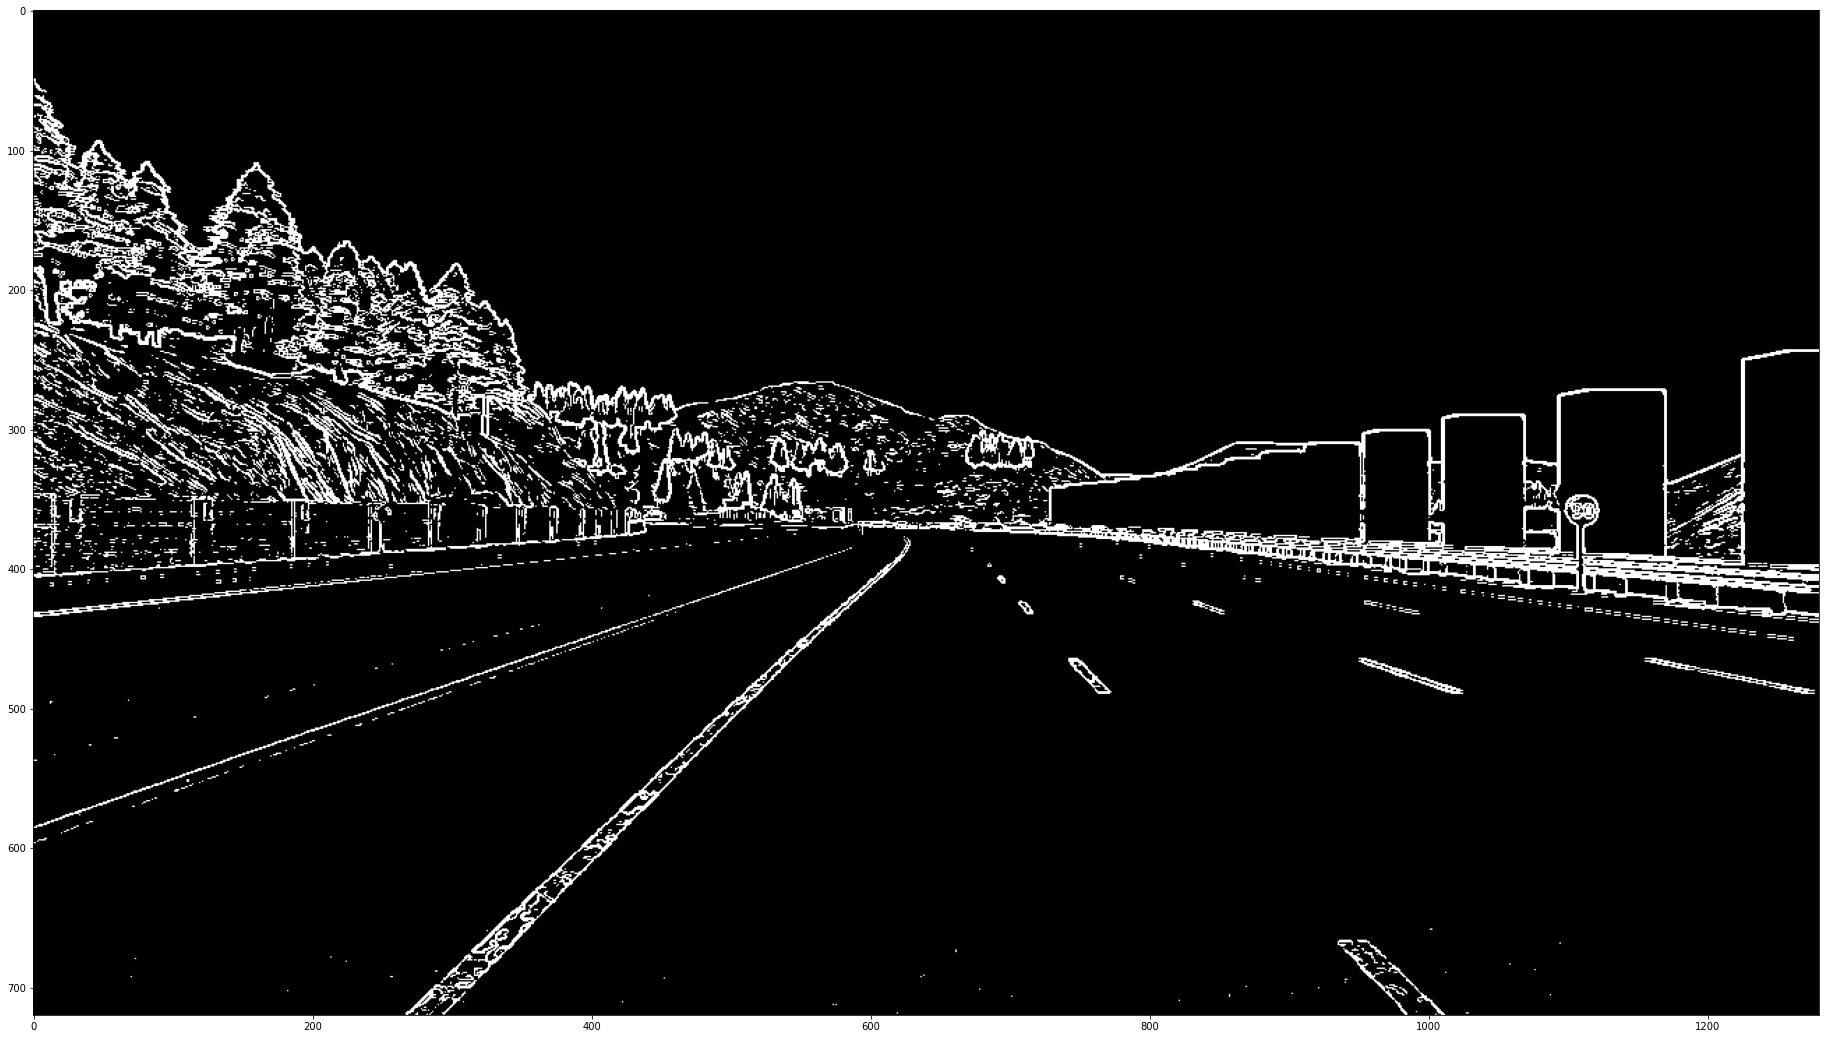

In [49]:
plt.figure(figsize=(32,20))
plt.imshow(bin_grad_x_y, cmap='gray')
plt.show()